# Importing libraries

In [1]:
from wfield import *
import tifffile
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import re
import shutil
import pandas as pd
import h5py
import matplotlib.gridspec as gridspec
from scipy.signal import detrend



# Defining functions

In [2]:
# new version

def plot_PSTH(data_df, stim_df, region, time_window_before, time_window_after, data_type):
    sides = ['left', 'right']
    print(f"PSTH for {region} in progress...")
    fig, axs = plt.subplots(nrows=1, ncols=len(sides), figsize=(21, 7))
    fig.set_facecolor('white')
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    for i, side in enumerate(sides):
        column_name = f'{region}_{side}_{data_type}'
        ax = axs[i]

        if column_name in data_df.columns:
            try:
                region_data = data_df[[column_name, 'time_seconds']]
                peri_stim_data_expected = []
                peri_stim_data_oddball = []
                offsets_expected = []
                offsets_oddball = []

                exp_onsets = stim_df.loc[stim_df['stim_id'] == 9, 'onset_idx'].tolist()
                odd_onsets = stim_df.loc[stim_df['stim_id'] == 10, 'onset_idx'].tolist()
                exp_offsets = stim_df.loc[stim_df['stim_id'] == 9, 'offset_idx'].tolist()
                odd_offsets = stim_df.loc[stim_df['stim_id'] == 10, 'offset_idx'].tolist()
                exp_mean_dur = stim_df.loc[stim_df['stim_id'] == 9, 'mean_dur'].tolist()
                odd_mean_dur = stim_df.loc[stim_df['stim_id'] == 10, 'mean_dur'].tolist()
                exp_sem_dur = stim_df.loc[stim_df['stim_id'] == 9, 'sem_dur'].tolist()
                odd_sem_dur = stim_df.loc[stim_df['stim_id'] == 10, 'sem_dur'].tolist()

                for onset, offset, mean_dur, sem_dur in zip(exp_onsets, exp_offsets, exp_mean_dur, exp_sem_dur):
                    start_idx = onset - time_window_before
                    end_idx = onset + time_window_after
                    if start_idx >= 0 and end_idx < len(region_data):
                        peri_stim_data_expected.append(region_data.iloc[start_idx:end_idx][column_name].values)
                        offsets_expected.append(offset - onset)
                
                for onset, offset, mean_dur, sem_dur in zip(odd_onsets, odd_offsets, odd_mean_dur, odd_sem_dur):
                    start_idx = onset - time_window_before
                    end_idx = onset + time_window_after
                    if start_idx >= 0 and end_idx < len(region_data):
                        peri_stim_data_oddball.append(region_data.iloc[start_idx:end_idx][column_name].values)
                        offsets_oddball.append(offset - onset)

                max_length = max(max(len(x) for x in peri_stim_data_expected), max(len(x) for x in peri_stim_data_oddball))
                peri_stim_data_expected = [np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan) if len(x) < max_length else x[:max_length] for x in peri_stim_data_expected]
                peri_stim_data_oddball = [np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan) if len(x) < max_length else x[:max_length] for x in peri_stim_data_oddball]

                mean_activity_expected = np.nanmean(peri_stim_data_expected, axis=0)
                sem_activity_expected = np.nanstd(peri_stim_data_expected, axis=0) / np.sqrt(np.sum(~np.isnan(peri_stim_data_expected), axis=0))
                mean_activity_oddball = np.nanmean(peri_stim_data_oddball, axis=0)
                sem_activity_oddball = np.nanstd(peri_stim_data_oddball, axis=0) / np.sqrt(np.sum(~np.isnan(peri_stim_data_oddball), axis=0))

                ax.plot(np.arange(-time_window_before, time_window_after), mean_activity_expected, label=f'{region} {side.capitalize()} - Expected', color='blue')
                ax.fill_between(np.arange(-time_window_before, time_window_after), mean_activity_expected - sem_activity_expected, mean_activity_expected + sem_activity_expected, color='blue', alpha=0.3)
                ax.plot(np.arange(-time_window_before, time_window_after), mean_activity_oddball, label=f'{region} {side.capitalize()} - Oddball', color='red')
                ax.fill_between(np.arange(-time_window_before, time_window_after), mean_activity_oddball - sem_activity_oddball, mean_activity_oddball + sem_activity_oddball, color='red', alpha=0.3)
                ax.axvline(x=0, linestyle='--', color='gray', label='Stimulus Onset')
                ax.axvline(x=np.mean(exp_mean_dur), linestyle='--', color='blue', label='Expected Stimulus Offset')
                ax.axvline(x=np.mean(odd_mean_dur), linestyle='--', color='red', label='Oddball Stimulus Offset')
                ax.axvspan(0, np.mean(exp_mean_dur), alpha=0.3, color='orange')
                ax.axvspan(0, np.mean(odd_mean_dur), alpha=0.3, color='pink')
                ax.axvspan(exp_mean_dur[0] - exp_sem_dur[0], exp_mean_dur[0] + exp_sem_dur[0], alpha=0.1, color='blue')
                ax.axvspan(odd_mean_dur[0] - odd_sem_dur[0], odd_mean_dur[0] + odd_sem_dur[0], alpha=0.1, color='red')
                ax.set_title(f'{region} {side}')
                ax.set_xlabel('Time (indices) relative to stimulus onset')
                ax.set_ylabel('Activity (z-score)')
                ax.legend()
                ax.grid(False)

            except Exception as err:
                print(f"Error plotting PSTH for {region} {side}: {err}")

        else:
            print(f"No data available for {region} {side}. Leaving subplot empty.")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(pjoin(localdisk, f'PSTH/Session/{region}_session_PSTH.pdf'))  # Saving the figure to the specified path
    print(f"PSTH for {region} saved...")
    plt.close(fig)


In [3]:


def plot_allPSTH(data_df, stim_df, region, time_window_before, time_window_after, data_type):
    sides = ['left', 'right']
    stimulus_info = {
        'A1': {'stim_id': 6, 'color': 'green'},
        'B2': {'stim_id': 7, 'color': 'lightblue'},
        'A3': {'stim_id': 8, 'color': 'lime'},
        'B4': {'stim_id': 9, 'color': 'blue'},
        'C4': {'stim_id': 10, 'color': 'red'}
    }

    print(f"PSTH for {region} in progress...")
    fig, axs = plt.subplots(nrows=1, ncols=len(sides), figsize=(21, 7))
    fig.set_facecolor('white')
    # plt.rcParams['font.family'] = 'serif'
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    for i, side in enumerate(sides):
        column_name = f'{region}_{side}_{data_type}'
        ax = axs[i]

        if column_name in data_df.columns:
            try:
                region_data = data_df[[column_name, 'time_seconds']]
                peri_stim_data = {key: [] for key in stimulus_info}
                offsets = {key: [] for key in stimulus_info}

                for stim_name, info in stimulus_info.items():
                    onsets = stim_df.loc[stim_df['stim_id'] == info['stim_id'], 'onset_idx'].tolist()
                    offsets_list = stim_df.loc[stim_df['stim_id'] == info['stim_id'], 'offset_idx'].tolist()

                    for onset, offset in zip(onsets, offsets_list):
                        start_idx = onset - time_window_before
                        end_idx = onset + time_window_after
                        if start_idx >= 0 and end_idx < len(region_data):
                            peri_stim_data[stim_name].append(region_data.iloc[start_idx:end_idx][column_name].values)
                            offsets[stim_name].append(offset - onset)

                # Process and plot each stimulus data
                for stim_name, data in peri_stim_data.items():
                    if data:
                        max_length = max(len(d) for d in data)
                        padded_data = [np.pad(d, (0, max_length - len(d)), 'constant', constant_values=np.nan) for d in data]

                        mean_activity = np.nanmean(padded_data, axis=0)
                        sem_activity = np.nanstd(padded_data, axis=0) / np.sqrt(np.sum(~np.isnan(padded_data), axis=0))

                        ax.plot(np.arange(-time_window_before, time_window_after), mean_activity, label=f'{region} {side.capitalize()} - {stim_name}', color=stimulus_info[stim_name]['color'])
                        ax.fill_between(np.arange(-time_window_before, time_window_after), mean_activity - sem_activity, mean_activity + sem_activity, color=stimulus_info[stim_name]['color'], alpha=0.3)

                ax.axvline(x=0, linestyle='--', color='gray', label='Stimulus Onset')
                for stim_name, info in stimulus_info.items():
                    mean_dur = np.mean([offsets[stim_name]])
                    ax.axvline(x=mean_dur, linestyle='--', color=stimulus_info[stim_name]['color'], label=f'{stim_name} Stimulus Offset')
                    ax.axvspan(0, mean_dur, alpha=0.3, color=stimulus_info[stim_name]['color'])

                ax.set_title(f'{region} {side}')
                ax.set_xlabel('Time (indices) relative to stimulus onset')
                ax.set_ylabel('Activity (z-score)')
                ax.legend()
                ax.grid(False)

            except Exception as err:
                print(f"Error plotting PSTH for {region} {side}: {err}")

        else:
            print(f"No data available for {region} {side}. Leaving subplot empty.")
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(pjoin(localdisk,f'PSTH/{region}_all_stimuli_PSTH.pdf'))  # Saving the figure to the specified path
    print(f"PSTH for {region} saved...")
    plt.close(fig)


In [4]:
def list_scans(data_folder, keyword):
    # Find folders containing the keyword
    scan_folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

    # Print list of found folders
    print(f"Folders containing '{keyword}' keyword:")
    for i, folder in enumerate(scan_folders):
        print(f"{i + 1}. {folder}")

    # Prompt user to choose a folder
    while True:
        choice = input("Enter the number of the scan you want to choose: ")
        if choice.isdigit() and 1 <= int(choice) <= len(scan_folders):
            chosen_folder = scan_folders[int(choice) - 1]
            break
        else:
            print("Invalid input. Please enter a valid number.")
    print("Selected",chosen_folder)
    # Return the path to the chosen folder
    return os.path.join(data_folder, chosen_folder), chosen_folder


In [5]:
def find_bins(localdisk):
    # Find all .tif files in the directory
    tif_files = [f for f in os.listdir(localdisk) if f.endswith('.tif')]
    
    # Find all .dat files in the directory
    dat_files = glob(pjoin(localdisk,'*.dat'))
    
    if len(dat_files) > 1:
        print("Multiple .dat files found:")
        for i, dat_file in enumerate(dat_files):
            print(f"{i + 1}. {os.path.basename(dat_file)}")
        
        while True:
            choice = input("Enter the number of the .dat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(dat_files):
                dat_path = dat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    
    elif len(dat_files) == 1:
        dat_path = dat_files[0]
    else:
        print("Binaries file not found")
        print("-----------------------")
        print("Concatenating TIF files...")
        print("-----------------------")
        tif_data_list = []
        for tif_file in sorted(tif_files):
            tif_file_path = os.path.join(localdisk, tif_file)
            tif_data = tifffile.imread(tif_file_path);
            tif_data_list.append(tif_data)
        concatenated_data = np.concatenate(tif_data_list, axis=0)
        print(concatenated_data.shape)
        # Splitting into violet and green channels
        violet_channel = concatenated_data[::2]  # Every second frame starting from the first
        green_channel = concatenated_data[1::2]  # Every second frame starting from the second

        # Ensure both channels have the same length (in case the number of frames is odd)
        if violet_channel.shape[0] > green_channel.shape[0]:
            violet_channel = violet_channel[:-1]
        h, w = green_channel.shape[1:]
        merged_data = np.stack((violet_channel, green_channel), axis=1)
        n_frames = merged_data.shape[0]
        filename_parts = re.split(r'_|\.', tif_files[0])
        scan_info = '_'.join(filename_parts[0:4])  # Joining parts 1 to 4 with underscores
        frame_shape = f"{h}_{w}"
        filename = f"{scan_info}_{frame_shape}_2_uint16.dat"
        print(f"Saving file in {filename}")
        save_path = os.path.join(localdisk, filename)
        merged_data.astype(np.uint16).tofile(save_path)
        del merged_data
        dat_path = dat_files[0]
    
    print("Binaries file found")
    print("Loading...")
    dat = mmap_dat(dat_path)
    n_frames, h, w, n_channels = dat.shape
    
    dat = mmap_dat(dat_path, mode='r+', nframes=n_frames, shape=(2, h, w))
    print(f'Loaded {n_frames} frames with {h} x {w} (height x width)')
    print("Selected", os.path.basename(dat_path))
    return dat, n_frames, h, w


In [6]:
def save_video_from_array(array, filename_prefix, folder, num_channels):
    n_frames, *shape = array.shape
    height, width = shape[-2:]

    # Create folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)

    if len(shape) == 2:  # Single channel
        channels_to_save = 1
    elif len(shape) == 3:  # Multiple channels
        channels_to_save = min(num_channels, shape[0])
    else:
        raise ValueError("Invalid array shape.")

    # Iterate over each channel
    for channel_idx in range(channels_to_save):
        # Create VideoWriter object
        filename = os.path.join(folder, f"{filename_prefix}_channel{channel_idx}.mp4")
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Change codec to MP4V for MP4 format
        out = cv2.VideoWriter(filename, fourcc, 25.0, (width, height))

        # Iterate over each frame
        for frame_idx in range(n_frames):
            # Extract channel if multiple channels, else use array directly
            channel_array = array[frame_idx, channel_idx] if len(shape) == 3 else array[frame_idx]

            # Normalize pixel values to 0-255 range
            channel_array = (channel_array - np.min(channel_array)) / (np.max(channel_array) - np.min(channel_array)) * 255

            # Convert to uint8
            frame = channel_array.astype(np.uint8)

            # Apply colormap if needed (e.g., for grayscale images)
            frame = cv2.applyColorMap(frame, cv2.COLORMAP_VIRIDIS)

            # Write frame to video file
            out.write(frame)

        # Release VideoWriter object
        out.release()

    print("Videos saved successfully.")

In [7]:
def dFF_percentile_detrend(fluorescence_data, percentile=10):
    """
    Calculate detrended dF/F₀ where F₀ is defined as a specific percentile of the baseline period.

    Parameters:
    - fluorescence_data (array-like): Fluorescence data.
    - base_start (int): Start index of the baseline period.
    - base_end (int): End index of the baseline period.
    - percentile (int): The percentile used to determine F₀.

    Returns:
    - dF_over_F0 (array): Array containing the detrended dF/F₀ values.
    - z_scores (array): Array containing the z-scores of the dF/F₀.
    """
    # Detrend the data
    detrended_data = detrend(fluorescence_data)
    
    # Calculate F₀ (baseline fluorescence) using a specified percentile of the baseline period
    # if base_end > base_start:
    #     F0 = np.percentile(detrended_data[base_start:base_end], percentile)
    # else:
    #     F0 = np.percentile(detrended_data, percentile)
    F0 = np.percentile(detrended_data, percentile)
    # Calculate dF (change in fluorescence)
    dF = detrended_data - F0
    
    # Calculate dF/F₀
    dF_over_F0 = dF / F0
    
    # Calculate z-scores for the dF/F₀ values
    z_scores = (dF_over_F0 - np.mean(dF_over_F0)) / np.std(dF_over_F0)
    
    return dF_over_F0, z_scores


In [8]:



def dFF_z(fluorescence_data, base_start, base_end):
    """
    Calculate dF/F₀ and z-scores for fluorescence data.

    Parameters:
    - fluorescence_data (array-like): Fluorescence data.
    - base_start (int): Start index of the baseline period.
    - base_end (int): End index of the baseline period.

    Returns:
    - dF_over_F0 (DataFrame): DataFrame containing the dF/F₀ values.
    - z_scores (DataFrame): DataFrame containing the z-scores.
    """
    # Calculate F₀ (baseline fluorescence)
    if base_end:
        F0 = np.mean(fluorescence_data[base_start:base_end])
        # print(f"Using as baseline frames: [{base_start}, {base_end}]")
    else:
        F0 = np.mean(fluorescence_data)
        # print("Using as baseline scan average")
    
    # Calculate dF (change in fluorescence)
    dF = fluorescence_data - F0
    
    # Calculate dF/F₀
    dF_over_F0 = dF / F0
    
    # Normalize dF/F₀ to 0-1 range
    dF_over_F0_min = np.min(dF_over_F0)
    dF_over_F0_max = np.max(dF_over_F0)
    dF_over_F0_normalized = (dF_over_F0 - dF_over_F0_min) / (dF_over_F0_max - dF_over_F0_min)
    
    # Convert normalized dF/F₀ to percentage
    dF_over_F0_percent = dF_over_F0_normalized * 100
    0
    # Calculate z-scores for the normalized dF/F₀ values
    z_scores = (dF_over_F0 - dF_over_F0.mean()) / np.std(dF_over_F0)
    # z_scores = (dF_over_F0_normalized - np.mean(dF_over_F0_normalized)) / np.std(dF_over_F0_normalized)
    
    
    return dF_over_F0, z_scores

In [9]:
def list_bpod(localdisk):
    import scipy.io
    mat_files = glob(pjoin(localdisk,'*.mat'))
    if len(mat_files) > 1:
        print("Multiple Bpod files found:")
        for i, mat_file in enumerate(mat_files):
            print(f"{i + 1}. {os.path.basename(mat_file)}")
        
        while True:
            choice = input("Enter the number of the .mat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(mat_files):
                mat_path = mat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    elif len(mat_files) == 1:
        mat_path = mat_files[0]
        print("Bpod file found")
        print("Loading...")
    else:
        print("Bpod file not found")
        print("-----------------------")
    
    try:
        bpod_data = scipy.io.loadmat(mat_path)
        print("Selected", os.path.basename(mat_path))
    except:
        print("Failed")
    return bpod_data


In [10]:
def list_mat(folder):
    import scipy.io
    mat_files = glob(pjoin(folder,'*.mat'))
    if len(mat_files) > 1:
        print("Multiple .mat files found:")
        for i, mat_file in enumerate(mat_files):
            print(f"{i + 1}. {os.path.basename(mat_file)}")
        
        while True:
            choice = input("Enter the number of the .mat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(mat_files):
                mat_path = mat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    elif len(mat_files) == 1:
        mat_path = mat_files[0]
        print("Mat file found")
        print(f"Loading... {mat_path}")
    else:
        print("No .mat files found.")
        print("-----------------------")

    try:
        # Check if it's a MATLAB v7.3 file by attempting to open with h5py
        with h5py.File(mat_path, 'r') as file:
            print("Selected", os.path.basename(mat_path), "(HDF5 format)")
            return {key: file[key][()] for key in file.keys()}  # Load the content using dictionary comprehension
    except OSError:  # If h5py cannot open it, assume it's an older version and use scipy.io.loadmat
        try:
            mat_data = scipy.io.loadmat(mat_path)
            print("Selected", os.path.basename(mat_path))
            return mat_data
        except Exception as err:
            print("Failed to load .mat file.")
            print(err)
            return None

# From SM analysis

In [12]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA")
print("--------------------------")


Folders containing 'AA' keyword:
1. Preconditioning_AA_ROS-1792_2024-06-06_scan9FOHHCKE_sess9FOHHCKE
2. Preconditioning_AA_ROS-1783_2024-06-06_scan9FOHGI54_sess9FOHGI54
3. Preconditioning_AA_ROS-1783_2024-06-04_scan9FOGAODU_sess9FOGAODU
4. Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG
5. Preconditioning_AA_ROS-1783_2024-06-07_scan9FOI2GOW_sess9FOI2GOW
6. PassConditioning_AA_ROS-1792_2024-06-10_scan9FOJUE5S_sess9FOJUE5S
7. AA_ROS-1688_2024_01_27_scan000WQU9_sess000EAEIO
8. Habituation_AA_ROS-1783_2024-05-28_scan9FOC20QN_sess9FOC1CUS
9. Preconditioning_AA_ROS-1783_2024-06-05_scan9FOGVB9K_sess9FOGVB9K
10. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEWPU_sess9FOKEEYA
11. PassConditioning_AA_ROS-1792_2024-06-12_scan9FOKYJK6_sess9FOKYJK6
12. AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG
13. PassConditioning_AA_ROS-1783_2024-06-09_scan9FOJAPFP_sess9FOJAPFP
14. Habituation_AA_ROS-1792_2024-06-04_scan9FOG9RQH_sess9FOG9RQH
15. Habituation_AA_ROS-1783_2024-05-31_scan9FODV06V_ses

In [13]:
SM_data = list_mat(localdisk)

Multiple .mat files found:
1. scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16_Vc.mat
2. scan9FN2ANVG_Oddball_AA_ROS-1706_2024_03_12_bpod.mat


Selected scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16_Vc.mat (HDF5 format)


In [14]:
# Assuming SM_data is your loaded dictionary containing 'U', 'newVc', etc.
U = SM_data['U']
newVc = SM_data['newVc']
# Correctly interpret the dimensions of U
num_components, height, width = U.shape  # U is (200, 600, 600)
n_frames = newVc.shape[0] 
# Reshape U into a 2D array where each row corresponds to a vectorized spatial component
U_reshaped = U.reshape(num_components, height * width)  # becomes (200, 360000)

# Multiply the reshaped U with the first 100 columns of newVc
# newVc is expected to be of the form (200, number of frames)
cData = U_reshaped.T @ newVc.T  # cData will be (360000, 100)

# Reshape cData back into the original spatial dimensions with 100 frames
cData_reshaped = cData.reshape(height, width, n_frames).transpose(2, 0, 1)


# Trial Onsets

### Reading Aux file

In [53]:
# data_folder = r'/datajoint-data/data/aeltona/'
# # tif_file_path = pjoin(data_folder, 'scan9FN2ANVG_Oddball_AA_ROS-1706_2025_MMStack_Default.ome.tif')
# # localdisk = r'C:\datatemp'

# localdisk, scan_idx = list_scans(data_folder,"AA")



In [15]:
h5_path = glob(pjoin(localdisk,'*.h5'))[0]
h5_path

'/datajoint-data/data/aeltona/AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG/scan9FN2ANVG_AA_ROS-1706_0002.h5'

In [16]:

# Open the HDF5 file
with h5py.File(h5_path, 'r') as f:
    # Access specific group
    # print(f.keys())
    sweep_data_key = list(f.keys())[1]
    sweep_data = f[sweep_data_key]
    header = f['header']
    # List all keys within the group
    # print(f"Keys in {sweep_data_key}: %s" % sweep_data.keys())
    # print("Keys in header: %s" % header.keys())
    
    
    AIChannelNames = header['AIChannelNames'][:]
    YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
    AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
    SampleRate = header['AcquisitionSampleRate'][:]
    analogData = sweep_data['analogScans'][:]
    # # Check if 'data' exists within the group
    # if 'analogScans' in sweep_data:
    #     data = sweep_data['analogScans'][:]  # accessing array dataset
    #     print("Data from sweep_0001:", data)
    # else:
    #     print("Dataset 'data' does not exist in sweep_0001.")

In [17]:
# Convert analogData to DataFrame
df = pd.DataFrame(analogData.T, columns=AIChannelNames)
sampling_rate_hz = SampleRate[0,0]
df['time_seconds'] = df.index / sampling_rate_hz
# Print DataFrame
# print(df)
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'Stim_ID', 'Stim_ON',
       'SoftCode', 'Lick Count', 'Rotary Encoder', 'time_seconds'],
      dtype='object')

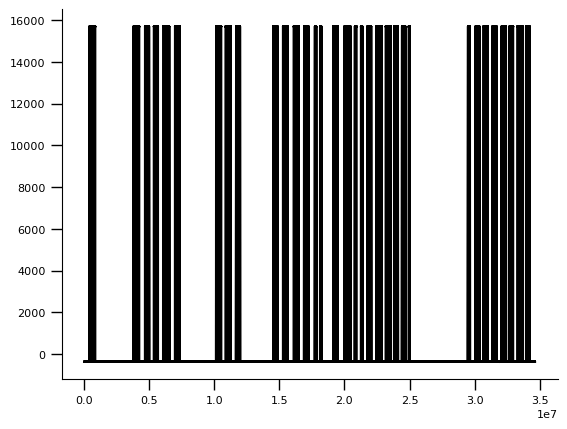

In [18]:
%matplotlib inline
plt.clf()
# plt.plot(df['HiFi_module']);
plt.plot(df['Stim_ON']);
plt.show()

In [19]:
Oddball, SP = True,False

if Oddball:
    norm_stim_id = df['Stim_ID']/3000
    norm_stim_id = norm_stim_id.round(0)
    norm_stim_on = (df['Stim_ON'] - df['Stim_ON'].min()) / (df['Stim_ON'].max() - df['Stim_ON'].min())
    norm_stim_on = norm_stim_on.round(0)
    df['norm_stim_on'] = norm_stim_on
    df['norm_stim_id'] = norm_stim_id
elif SP:
    print('to be done')
    df['HiFi_norm']= df["HiFi_module"] / df["HiFi_module"].max()

norm_blue_on = (df['blue_470nm'] - df['blue_470nm'].min()) / (df['blue_470nm'].max() - df['blue_470nm'].min())
norm_blue_on = norm_blue_on.round(0)
df['norm_blue_on'] = norm_blue_on

blue_df = df[df['norm_blue_on'] == 1]

points_per_frame = len(blue_df) // n_frames
blue_df_reshaped = pd.DataFrame()
for col in blue_df.columns:
    reshaped_col = blue_df[col].values[:points_per_frame * n_frames].reshape(n_frames, -1)
    blue_df_reshaped[col] = reshaped_col[:, 0]
data_df = blue_df_reshaped
data_df.shape
# norm_blue_on.unique()

(8619, 12)

In [20]:
diffs = np.diff(norm_blue_on)

frames  = np.where(diffs>0)
len(frames[0])


8619

### Reading Bpod Data


In [21]:
bpod_data = list_bpod(localdisk)

Multiple Bpod files found:
1. scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16_Vc.mat
2. scan9FN2ANVG_Oddball_AA_ROS-1706_2024_03_12_bpod.mat
Selected scan9FN2ANVG_Oddball_AA_ROS-1706_2024_03_12_bpod.mat


### SP

In [126]:
data_df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HiFi_module', 'Reward',
       'SoftCode', 'Lick Spout', 'Rotary Encoder', 'time_seconds',
       'norm_blue_on', 'HiFi_norm'],
      dtype='object')

In [122]:
trial_onsets = bpod_data['SessionData'][0, 0]['TrialStartTimestamp'][0]
trial_types = bpod_data['SessionData'][0, 0]['TrialTypes'][0]
n_trials = bpod_data['SessionData'][0, 0]['nTrials'][0][0]
odd_trials = np.where(trial_types==2)
# stim1 = bpod_data['SessionData'][0, 0]['Stim1'][0]

array([6.2839, 8.7839])

In [143]:
for key in bpod_data:
    print(f"{key}: {type(bpod_data[key])}")

__header__: <class 'bytes'>
__version__: <class 'str'>
__globals__: <class 'list'>
SessionData: <class 'numpy.ndarray'>


In [151]:
session_data = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0,0][0,2]['States'][0,0]
# print(session_data.dtype.names)
# print(session_data.shape)
session_data

array([[(array([[0.    , 0.5638]]), array([[0.5638, 0.6767]]), array([[0.6767, 0.6768]]), array([[0.6768, 2.231 ]]), array([[2.231 , 2.2413]]), array([[2.2413, 2.2414]]), array([[2.2414, 4.6513]]), array([[4.6513, 4.6514]]), array([[4.6514, 9.8939]]), array([[nan, nan]]), array([[nan, nan]]), array([[nan, nan]]), array([[nan, nan]]), array([[nan, nan]]), array([[nan, nan]]), array([[nan, nan]]))]],
      dtype=[('WaitForPreconditioningStart', 'O'), ('WaitForTriggerStartSoftCode', 'O'), ('SendTrialSoftCode', 'O'), ('WaitForVisCues', 'O'), ('TriggerCues', 'O'), ('VisCueB_ON', 'O'), ('PlaySoundB', 'O'), ('FastVisCueB_OFF', 'O'), ('WaitForVREnd', 'O'), ('VisCueA_ON', 'O'), ('PlaySoundA', 'O'), ('WaitVisCueA_OFF', 'O'), ('WaitVisCueB_OFF', 'O'), ('VisCueA_OFF', 'O'), ('VisCueB_OFF', 'O'), ('FastVisCueA_OFF', 'O')])

In [129]:
data_df['HiFi_norm'] = data_df['HiFi_norm'].round(0)
data_df['HiFi_norm'].unique()

array([-0.,  1.])

In [130]:
first_stim_bpod = stim_1[0]
first_stim_df_index = data_df[data_df['HiFi_norm'] == 1].index[0]
first_stim_df_time = data_df.loc[first_stim_df_index, 'time_seconds']
time_delay = first_stim_df_time - (first_stim_bpod + trial_onsets[0])
adjusted_trial_onsets = trial_onsets + time_delay
data_df['trial_onsets'] = 0
# Mark the frames (rows) corresponding to the adjusted trial onsets
for onset in adjusted_trial_onsets:
    # Find the closest frame (row) in data_df corresponding to each adjusted trial onset
    closest_idx = (np.abs(data_df['time_seconds'] - onset)).idxmin()
    data_df.at[closest_idx, 'trial_onsets'] = 1

In [140]:
data_df['stim_type'] = 0


30

In [154]:
# Identify the points where 'HiFi_norm' changes from 0 to 1 and from 1 to 0
transitions_to_one = data_df['HiFi_norm'].diff() == 1
transitions_from_one = data_df['HiFi_norm'].diff() == -1

# Find the indices where these transitions occur
starts = data_df.index[transitions_to_one].tolist()
ends = data_df.index[transitions_from_one].tolist()

# If the series ends with a 1, the last group won't have an end, handle this case:
if data_df['HiFi_norm'].iloc[-1] == 1:
    ends.append(len(data_df))

# Create a list of start and end pairs
start_end_pairs = list(zip(starts, ends))

print(start_end_pairs[0])

(84, 97)


In [158]:
for trial in odd_trials[0]:
    start, end = start_end_pairs[trial]
    data_df.loc[start:end, 'stim_type'] = 2

In [162]:
# Mark all other trials as type 1
all_trials = set(range(len(start_end_pairs)))  # Set of all trial indices
non_odd_trials = all_trials - set(odd_trials[0])  # Set difference to find non-odd trials

non_odd_trials
for trial in non_odd_trials:
    start, end = start_end_pairs[trial]
    data_df.loc[start:end, 'stim_type'] = 1

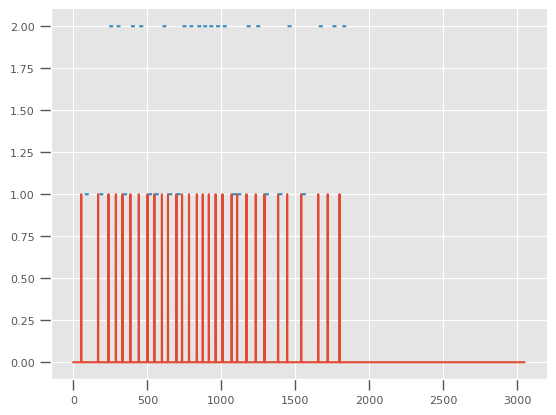

In [163]:
plt.plot(data_df['trial_onsets']);
plt.plot(data_df['stim_type']);

### oddball

In [22]:
trial_onsets = bpod_data['SessionData'][0, 0]['TrialStartTimestamp'][0]
trial_types = bpod_data['SessionData'][0, 0]['TrialTypes'][0]
n_trials = bpod_data['SessionData'][0, 0]['nTrials'][0][0]

stim_1 = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0,0][0,0]['States'][0,0]['Stimulus4On'][0,0][0,:]


reward =  bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0,0][0,0]['States'][0,0]['Reward'][0,0][0,:]
odd_trials = np.where(trial_types==2)


In [23]:
data_df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'Stim_ID', 'Stim_ON',
       'SoftCode', 'Lick Count', 'Rotary Encoder', 'time_seconds',
       'norm_stim_on', 'norm_stim_id', 'norm_blue_on'],
      dtype='object')

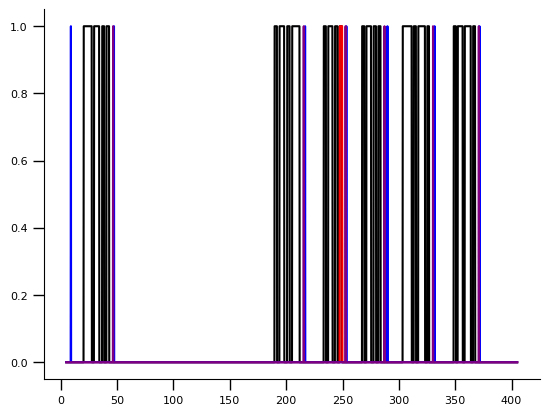

In [24]:
first_stim_bpod = stim_1[0]

# Find the first stimulus time in data_df
first_stim_df_index = data_df[data_df['norm_stim_on'] == 1].index[0]
first_stim_df_time = data_df.loc[first_stim_df_index, 'time_seconds']

# Calculate the time delay between data_df and Bpod
time_delay = first_stim_df_time - (first_stim_bpod + trial_onsets[0])

# Adjust the Bpod trial onsets by the time delay
adjusted_trial_onsets = trial_onsets + time_delay
# Create a new column in data_df for trial onsets, initialized to 0
data_df['trial_onsets'] = 0
# Mark the frames (rows) corresponding to the adjusted trial onsets
for onset in adjusted_trial_onsets:
    # Find the closest frame (row) in data_df corresponding to each adjusted trial onset
    closest_idx = (np.abs(data_df['time_seconds'] - onset)).idxmin()
    data_df.at[closest_idx, 'trial_onsets'] = 1

adjusted_odd_stim = []
for trial_num in odd_trials[0]:
    oddball = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0,0][0,trial_num]['States'][0,0]['Stimulus1On'][0,0][0,:]
    
    adjusted = oddball + trial_onsets[trial_num] +  time_delay# + time_delay
    # print(oddball,trial_onsets[trial_num],adjusted)
    adjusted_odd_stim.append(adjusted)

adjusted_reward_onsets = []
for trial_num in range(0, n_trials):
    reward =  bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0,0][0,trial_num]['States'][0,0]['Reward'][0,0][0,:]
    adjusted = reward + trial_onsets[trial_num] +  time_delay
    adjusted_reward_onsets.append(adjusted)


# adjusted_odd_stim
data_df['oddball_onsets'] = 0

for onset_offset in adjusted_odd_stim:
    onset, offset = onset_offset
    # Find indices where the time is within the onset and offset range
    indices_in_range = data_df[(data_df['time_seconds'] >= onset) & (data_df['time_seconds'] <= offset)].index
    # Set the corresponding rows in 'oddball_onsets' to 1
    data_df.loc[indices_in_range, 'oddball_onsets'] = 1

data_df['reward_onsets'] = 0

for onset_offset in adjusted_reward_onsets:
    onset, offset = onset_offset
    indices_in_range = data_df[(data_df['time_seconds'] >= onset) & (data_df['time_seconds'] <= offset)].index
    data_df.loc[indices_in_range, 'reward_onsets'] = 1

start = 0
end = 2000


plt.plot(data_df['time_seconds'][start:end],data_df['norm_stim_on'][start:end],color = 'black');
plt.plot(data_df['time_seconds'][start:end],data_df['oddball_onsets'][start:end],color = 'r');
plt.plot(data_df['time_seconds'][start:end],data_df['trial_onsets'][start:end],color = 'b');
plt.plot(data_df['time_seconds'][start:end],data_df['reward_onsets'][start:end],color = 'purple');



# Match Dorsal Cortex to the Allen Atlas

## Frame averaging

In [25]:
dat, n_frames, h, w = find_bins(localdisk)


Multiple .dat files found:
1. scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16.dat
2. motioncorrected_scan9FN2ANVG_Oddball_AA_ROS-1706_475_600_2_uint16.dat
3. motioncorrected_scan9FN2ANVG_Oddball_AA_ROS-1706_600_600_2_uint16.dat
Binaries file found
Loading...
Loaded 8619 frames with 475 x 600 (height x width)
Selected motioncorrected_scan9FN2ANVG_Oddball_AA_ROS-1706_475_600_2_uint16.dat


In [61]:
tif_files = [f for f in os.listdir(localdisk) if f.endswith('.tif')]

filename_parts = re.split(r'_|\.', tif_files[0])
scan_info = '_'.join(filename_parts[0:4])  # Joining parts 1 to 4 with underscores
frame_shape = f"{h}_{w}"

In [62]:
try:
    frames_average = np.load(pjoin(localdisk,'frames_average_uncropped.npy'))
    print("Found frames average")
except:
    print("Frames average not found, averaging...")
    nbaseline_frames = 10
    trial_onsets = data_df['trial_onsets']
    onsets = np.where(trial_onsets == 1)[0]

    frames_average_trials = frames_average_for_trials(dat,
                                                        onsets,
                                                        nbaseline_frames)

    frames_average = frames_average_trials.mean(axis=0)
    print("Saving average per trial")    
    np.save(pjoin(localdisk,'frames_average_trials_uncropped.npy'), frames_average)

    frames_average = dat.mean(axis=0)
    print("Saving average of the whole movie")
    np.save(pjoin(localdisk,'frames_average_uncropped.npy'), frames_average)


Found frames average


## Matching to Atlas

In [31]:
# frames_average = np.load(pjoin(localdisk,'frames_average.npy'))
frames_average = np.load(pjoin(localdisk,'frames_average_uncropped.npy'))


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
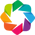

In [37]:
from bokeh.plotting import show



resolution = 0.0155 # mm per pixel
image = frames_average[0] # load a frame from the references 
bregma_offset = (np.array(image.shape[::-1])/2).astype('int')

ccf_regions,proj,brain_outline = allen_load_reference('dorsal_cortex')

# Get or load landmarks, these are for the allen dorsal cortex dataset
landmarks = {'x': [-1.95, 0, 1.95, 0],
             'y': [-3.45, -3.45, -3.45, 3.2],
             'name': ['OB_left', 'OB_center', 'OB_right', 'RSP_base'],
             'color': ['#fc9d03', '#0367fc', '#fc9d03', '#fc4103']}
landmarks = pd.DataFrame(landmarks)

# Load holoviews with the bokeh backend
import holoviews as hv
hv.extension('bokeh')

In [38]:
landmarks = {'x': [-1.95, 0, 1.95, 0],
             'y': [-3.45, -3.45, -3.45, 3.2],
             'name': ['OB_left', 'OB_center', 'OB_right', 'RSP_base'],
             'color': ['#fc9d03', '#0367fc', '#fc9d03', '#fc4103']}

wid,lmark_wid = hv_adjust_reference_landmarks(landmarks,ccf_regions)
wid

BokehModel(combine_events=True, render_bundle={'docs_json': {'486a870e-a152-4360-88bc-de77aaa4bce9': {'version…

In [39]:
# Get the new landmarks (save these somewhere)
# WARNING: This only works if you change something (edit the table)
landmarks = pd.DataFrame(lmark_wid.data)[['x','y','name','color']] # landmarks in allen_coords

save_allen_landmarks(landmarks,
                     resolution = resolution,
                     bregma_offset = bregma_offset)
landmarks

x     y       name    color
0 -1.95 -3.45    OB_left  #fc9d03
1  0.00 -3.45  OB_center  #0367fc
2  1.95 -3.45   OB_right  #fc9d03
3  0.00  3.20   RSP_base  #fc4103

In [40]:
from wfield import *

# load data and references
# localdisk = '/home/joao/dual/temp_folder/'
# frames_average = np.load(pjoin(localdisk,'frames_average_trials.npy'))
image = frames_average[0]
lmarks = load_allen_landmarks(None)
landmarks = lmarks['landmarks']
if 'landmarks_match' in lmarks.keys():
    landmarks_match = lmarks['landmarks_match']
else:
    landmarks_match = None
# bregma_offset = lmarks['bregma_offset']
# bregma_offset = [300,320]
bregma_offset = [300,320]

resolution = lmarks['resolution']

# The following line lets you plot previous landmarks
# how to load a transform
# landmarks_match = landmarks_match[['x','y','name','color']]


wid,lmark_wid,landmarks_im = hv_adjust_image_landmarks(image,landmarks,
                                                       landmarks_match = landmarks_match,
                                                       bregma_offset = bregma_offset,
                                                       resolution = resolution)
wid

BokehModel(combine_events=True, render_bundle={'docs_json': {'7e5976bb-9bcd-4cef-8972-b0059778f093': {'version…

In [41]:
# bregma_offset = [100,320]
# bregma_offset = [320,200]

resolution = 0.017

# Get the similarity transform and plot the result
landmarks_match = pd.DataFrame(lmark_wid.data)
M = allen_transform_from_landmarks(landmarks_im,landmarks_match)
overlay = hv_show_transformed_overlay(frames_average[0], M, ccf_regions,bregma_offset=bregma_offset,resolution = resolution)
show(hv.render(overlay))

In [42]:
# Save the transform and the reference points
save_allen_landmarks(landmarks,
                    #  filename = pjoin(localdisk,'ccf_transform.json'),
                     filename = pjoin(localdisk,'ccf_transform_landmarks.json'),
                     landmarks_match=landmarks_match,
                     transform=M,
                     resolution = resolution,
                     bregma_offset = bregma_offset)
print('''Transform:
    - scale {0}
    - translation {1}
    - rotation {2}'''.format(M.scale,M.translation,np.rad2deg(M.rotation)))

Transform:
    - scale 0.8785543791197209
    - translation [67.93432794 -1.70360551]
    - rotation 2.7452244195001807


In [43]:
# Plot an allen reference with holoviews
allen_regions = hv_plot_allen_regions(ccf_regions).options(width = w, height=h)
show(hv.render(allen_regions))

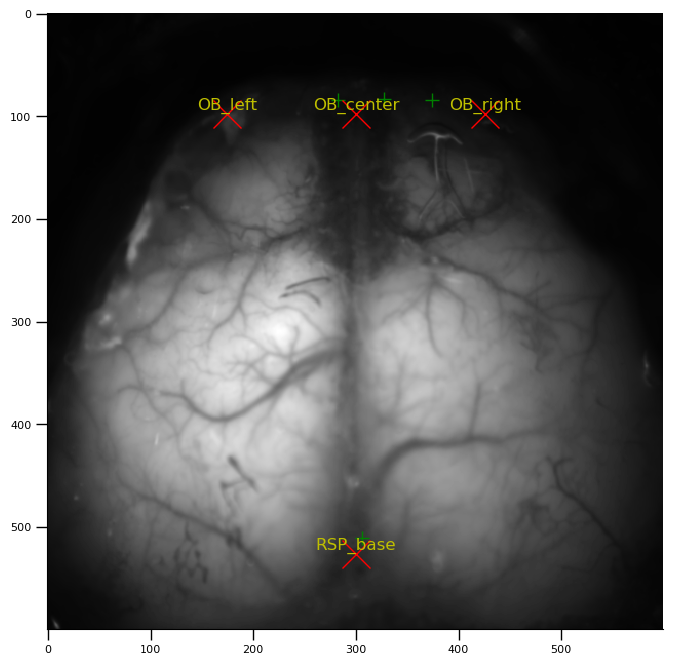

In [44]:
# Plot with matplotlib (example)
%matplotlib inline
plt.figure(figsize=[8,8])
h,w = image.shape
plt.imshow(im_apply_transform(image,M),
           cmap='gray')
for i,r in landmarks_im.iterrows():
    m = landmarks_match.loc[i]
    plt.plot(m.x,m.y,'g+',ms=10)
    plt.plot(r.x,r.y,'rx',ms=20)
    plt.text(r.x,r.y,r['name'],color='y',fontsize=12,va='bottom',ha='center')

plt.show()

# Warping Stack ROIs

In [26]:
import pylab as plt
from wfield import nb_play_movie
from wfield import SVDStack

In [27]:
# sm_path = pjoin(localdisk)
# print(sm_path)
localdisk, scan_idx = list_scans(data_folder,"AA")

SM_data = list_mat(localdisk)

# Assuming SM_data is your loaded dictionary containing 'U', 'newVc', etc.
U = SM_data['U']
newVc = SM_data['newVc']
# Correctly interpret the dimensions of U
num_components, height, width = U.shape  # U is (200, 600, 600)
n_frames = newVc.shape[0] 
# Reshape U into a 2D array where each row corresponds to a vectorized spatial component
U_reshaped = U.reshape(num_components, height * width)  # becomes (200, 360000)

# Multiply the reshaped U with the first 100 columns of newVc
# newVc is expected to be of the form (200, number of frames)
cData = U_reshaped.T @ newVc.T  # cData will be (360000, 100)

# Reshape cData back into the original spatial dimensions with 100 frames
cData_reshaped = cData.reshape(height, width, n_frames).transpose(2, 0, 1)
U_t = U.transpose(1, 2, 0)
newVc_t = newVc.T

stack = SVDStack(U_t,newVc_t)



Folders containing 'AA' keyword:
1. Preconditioning_AA_ROS-1792_2024-06-06_scan9FOHHCKE_sess9FOHHCKE
2. Preconditioning_AA_ROS-1783_2024-06-06_scan9FOHGI54_sess9FOHGI54
3. Preconditioning_AA_ROS-1783_2024-06-04_scan9FOGAODU_sess9FOGAODU
4. Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG
5. Preconditioning_AA_ROS-1783_2024-06-07_scan9FOI2GOW_sess9FOI2GOW
6. PassConditioning_AA_ROS-1792_2024-06-10_scan9FOJUE5S_sess9FOJUE5S
7. AA_ROS-1688_2024_01_27_scan000WQU9_sess000EAEIO
8. Habituation_AA_ROS-1783_2024-05-28_scan9FOC20QN_sess9FOC1CUS
9. Preconditioning_AA_ROS-1783_2024-06-05_scan9FOGVB9K_sess9FOGVB9K
10. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEWPU_sess9FOKEEYA
11. PassConditioning_AA_ROS-1792_2024-06-12_scan9FOKYJK6_sess9FOKYJK6
12. AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG
13. PassConditioning_AA_ROS-1783_2024-06-09_scan9FOJAPFP_sess9FOJAPFP
14. Habituation_AA_ROS-1792_2024-06-04_scan9FOG9RQH_sess9FOG9RQH
15. Habituation_AA_ROS-1783_2024-05-31_scan9FODV06V_ses

In [28]:


# U_old = np.load(pjoin(localdisk,'U.npy'))
# SVT_old = np.load(pjoin(localdisk,'SVTcorr.npy'))
# stack = SVDStack(U,SVT)
# stack = cData_reshaped

lmarks = load_allen_landmarks(pjoin(localdisk,'ccf_transform_landmarks.json'))

ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
# the reference is in allen CCF space and needs to be converted
# this converts to warped image space (accounting for the transformation)
ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                      resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(localdisk,'ccf_transform_landmarks.json')) # this loads the atlas in transformed coords

# this does the transform (warps the original images)
stack.set_warped(1, M = lmarks['transform']) # this warps the spatial components in the stack


In [29]:
# this converts the reference to image space (unwarped)
ref_folder = '/home/aeltona/wfield/references'
atlas, areanames, brain_mask = atlas_from_landmarks_file(pjoin(ref_folder,'dorsal_cortex_landmarks.json'),do_transform = True) # this loads the untransformed atlas
ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

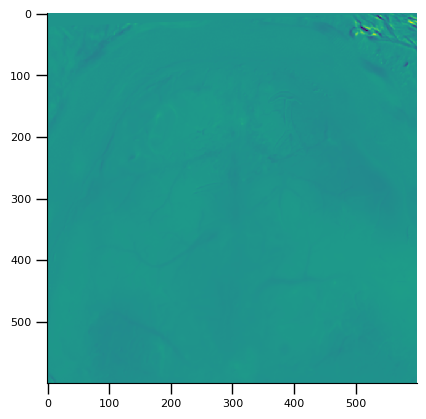

In [72]:
plt.imshow(stack.U_warped[:,:,40]);

(-0.5, 599.5, 599.5, -0.5)

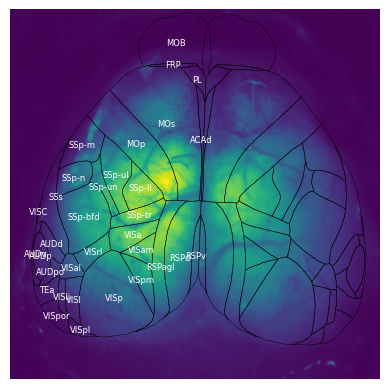

In [75]:
# areas = ['VISp','VISam','RSPagl','RSPd']

frames_average = np.load(pjoin(localdisk,'frames_average_uncropped.npy'))
image = frames_average[0]


lmarks = load_allen_landmarks(pjoin(localdisk,'ccf_transform_landmarks.json'))

ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(localdisk,'ccf_transform_landmarks.json')) # this loads the atlas in transformed coords


for i,r in ccf_regions_im.iterrows():
    
    # for area in areas:
    #     if r['acronym'] == area:
            for side in ['left', 'right']:
                plt.plot(np.array(r[side+'_x']), np.array(r[side+'_y']), 'k', lw=0.3)
                
                if side == 'left':  # Only plot text for the left side
                    # Calculate the centroid of the left region
                    centroid_x = np.mean(r[side+'_x'])
                    centroid_y = np.mean(r[side+'_y'])
                    
                    # Plot the acronym at the centroid position
                    plt.text(centroid_x, centroid_y, r['acronym'], color='white', fontsize=6, ha='center', va='center')
plt.imshow(image)
# plt.imshow(stack.U_warped[:,:,40]);
# plt.imshow(brain_mask)
plt.axis('off')

In [77]:
stack.set_warped(True)
for area_number in range(0,len(areanames)):
    area_name = str(areanames[area_number][1])
    area = areanames[area_number][0]

(540, 640)

In [43]:
image.shape

(600, 600)

In [108]:
stack.set_warped(True)
print(stack.get_timecourse(np.where(atlas == 33)).shape)

stack.set_warped(False)
print(stack.get_timecourse(np.where(atlas_im == 33)).shape)



(6862, 8619)


(11886, 8619)


(2000.0, 2500.0)

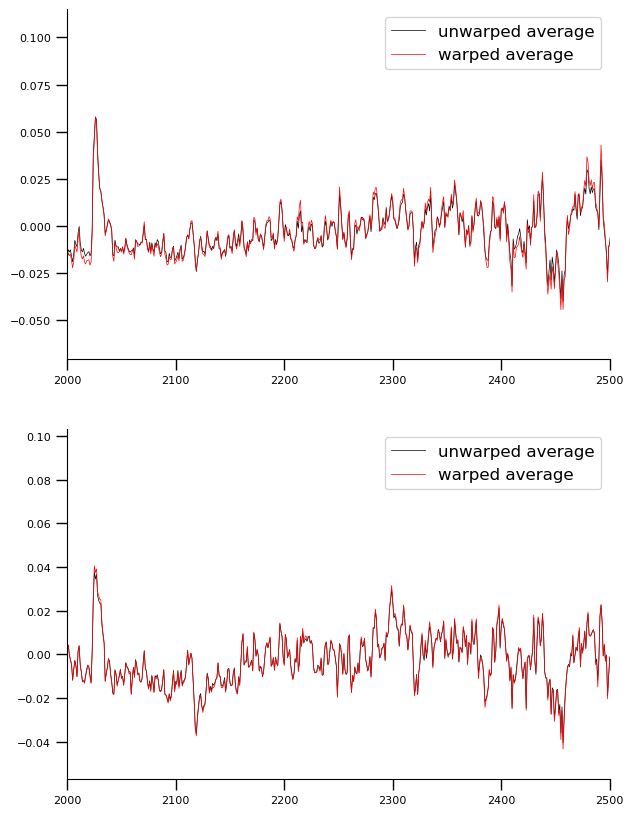

In [67]:
# Lets compare the warped with the unwarped average activity in an area
# area 33 is VISp
area = 33
stack.set_warped(True) # once this is done once the transform is set and you can alternate between the 2 modes.
warped = stack.get_timecourse(np.where(atlas == area)).mean(axis = 0)
stack.set_warped(False)
unwarped = stack.get_timecourse(np.where(atlas_im == area)).mean(axis = 0)

fig = plt.figure(figsize = [7,10])
fig.add_subplot(2,1,1)
plt.plot(unwarped,'k',lw = .5,label = 'unwarped average')
plt.plot(warped,'r',lw = .5,label = 'warped average')
plt.legend();
plt.xlim([2000,2500])
# plt.ylim([-0.04,0.06]);

area = -33 # plot the other side
stack.set_warped(True) 
warped = stack.get_timecourse(np.where(atlas == area)).mean(axis = 0)
stack.set_warped(False)
unwarped = stack.get_timecourse(np.where(atlas_im == area)).mean(axis = 0)

fig.add_subplot(2,1,2)
plt.plot(unwarped,'k',lw = .5,label = 'unwarped average')
plt.plot(warped,'r',lw = .5,label = 'warped average')
plt.legend()
plt.xlim([2000,2500])

# plt.xlim([20000,20500])
# plt.ylim([-0.04,0.06]);

In [34]:
# # Plot the first 20 spatial components of the transformed dataset and the raw dataset
# fig = plt.figure(figsize = [15,10])
# ncomponents = 20
# for icomponent in range(ncomponents):
#     fig.add_subplot(5,4,icomponent+1)
#     plt.imshow(np.concatenate([stack.originalU[:,:,icomponent],
#                                stack.U_warped[:,:,icomponent]],axis = 1),
#                clim=[-0.01,0.01],cmap='Spectral_r')
#     # plot the regions overlayed on the raw images
#     for i,r in ccf_regions_im.iterrows():
#         plt.plot(r['left_x'],r['left_y'],'k',lw=0.3)
#     # plot the raw reference because the images were converted
#     for i,r in ccf_regions.iterrows():
#         plt.plot(np.array(r['left_x'])+stack.U.shape[1],r['left_y'],'k',lw=0.3)
#     plt.axis('off')

## Plot 20 random frames of the transformed dataset and the raw dataset 
(sanity check: what does the transform do to the images)

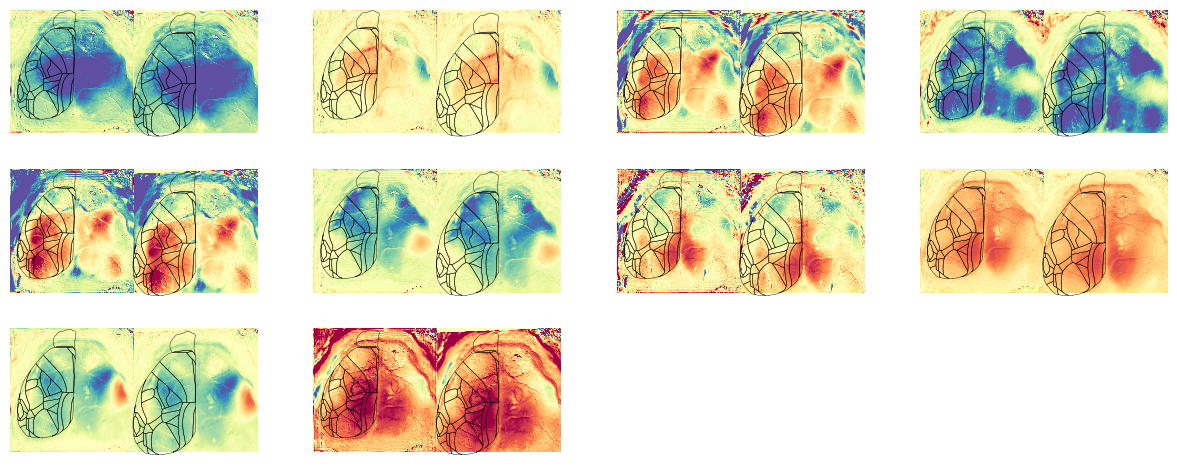

In [109]:

# Plot the 20 frames of the transformed dataset and the raw dataset
fig = plt.figure(figsize = [15,10])
for i,iframe in enumerate(np.random.choice(np.arange(0,stack.shape[0]),10)):
    fig.add_subplot(5,4,i+1)
    plt.imshow(np.concatenate([reconstruct(stack.originalU,stack.SVT[:,iframe]),
                               reconstruct(stack.U_warped,stack.SVT[:,iframe])],axis = 1),
               clim=[-0.03,0.03],cmap='Spectral_r')
    # plot the regions overlayed on the raw images
    for i,r in ccf_regions_im.iterrows():
        plt.plot(r['left_x'],r['left_y'],'k',lw=0.3)
    # plot the raw reference because the images were converted
    for i,r in ccf_regions.iterrows():
        plt.plot(np.array(r['left_x'])+stack.U.shape[1],r['left_y'],'k',lw=0.3)
    plt.axis('off')

## Highlight the differences in the atlas and ROIs in both warped and raw spaces

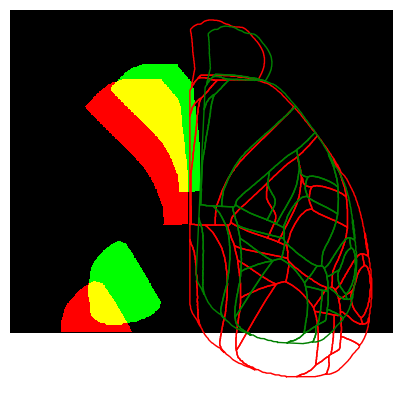

In [69]:
# Plot the overlap for the same region in the warped versus unwarped atlases 
plt.figure(figsize = [5,5])
area1 = 4
area2 = 33
reg = np.zeros([*atlas.shape,3])
reg[:,:,0] = np.array((atlas == area1) | (atlas == area2))*255
reg[:,:,1] = np.array((atlas_im == area1) | (atlas_im == area2))*255
plt.imshow(reg.astype('uint8'))

for i,r in ccf_regions.iterrows():
    for side in ['right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'r',lw=1)
for i,r in ccf_regions_im.iterrows():
    for side in ['right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'g',lw=1)
plt.axis('off');

## Explore the converted stack on the notebook

Saving movie : 16464it [11:20, 24.21it/s]00:00<?, ?it/s]
Saving movie : 12917it [05:41, 37.85it/s]                           


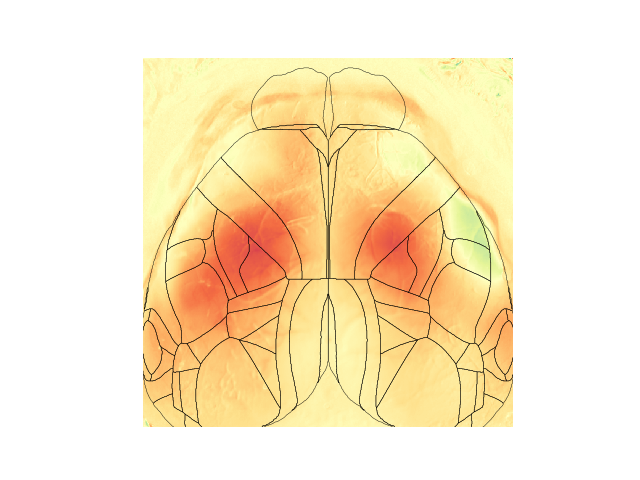

Saved to /datajoint-data/data/aeltona/Oddball_AA_ROS-1706_2024-03-12_scan9FN2BCOS_sess9FN2ANVG/whole_movie.avi


In [77]:
filename = pjoin(localdisk, 'movie_im.avi')

# play a movie of the stack with the regions overlayed
fig = plt.figure()
# This is for stack.set_warped(True)
stack.set_warped(True)
for i,r in ccf_regions_im.iterrows():
    for side in ['left','right']:
        plt.plot(np.array(r[side+'_x']),r[side +'_y'],'k',lw=0.3);
plt.axis('off')
# nb_play_movie(stack,cmap = 'Spectral_r',clim=[-0.04,0.04]);
nb_save_movie(stack,filename,interval=200, cmap = 'Spectral_r',clim=[-0.04,0.04]);


# Calculate ΔF/F and Z-score

In [70]:

data_df.shape[0]

12916

In [71]:
data_df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'Stim_ID', 'Stim_ON',
       'SoftCode', 'Lick Count', 'Rotary Encoder', 'time_seconds',
       'norm_stim_on', 'norm_stim_id', 'norm_blue_on', 'trial_onsets',
       'oddball_onsets', 'reward_onsets'],
      dtype='object')

In [121]:
# base_start, base_end = sorted_intervals[2]
# base_start, base_end = 1,11


# U = np.load(pjoin(localdisk,'U_uncropped.npy'))
# SVT = np.load(pjoin(localdisk,'SVTcorr_uncropped.npy'))

lmarks = load_allen_landmarks(pjoin(localdisk,'ccf_transform_landmarks.json'))

ccf_regions_im = allen_transform_regions(lmarks['transform'],ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                        bregma_offset = lmarks['bregma_offset'])

atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(localdisk,'ccf_transform_landmarks.json')) # this loads the atlas in transformed coords

# stack = SVDStack(U,SVT)
stack.set_warped(True)
for area_number in range(0,len(areanames)):
    area_name = str(areanames[area_number][1])
    area = areanames[area_number][0]
    # print(area,area_name)
    try:
        data = stack.get_timecourse(np.where(atlas_im == area)).mean(axis = 0)
        # dFF, zscore = dFF_z(data,base_start,base_end);
        dFF, zscore = dFF_percentile_detrend(data)
        data_df[f'{area_name}_dFF'] = dFF
        data_df[f'{area_name}_z'] = zscore
        print(area_name, 'loaded')
    except Exception as e:
        print(f"An error occurred: {e} ",area_name, 'failed')


MOB_left loaded
MOB_right loaded
FRP_left loaded
FRP_right loaded
MOp_left loaded
MOp_right loaded
MOs_left loaded
MOs_right loaded
SSp-n_left loaded
SSp-n_right loaded
SSp-m_left loaded
SSp-m_right loaded
SSp-un_left loaded
SSp-un_right loaded
PL_left loaded
PL_right loaded
ACAd_left loaded
ACAd_right loaded
RSPv_left loaded
RSPv_right loaded
RSPd_left loaded
RSPd_right loaded
RSPagl_left loaded
RSPagl_right loaded
VISC_left loaded
VISC_right loaded
SSs_left loaded
SSs_right loaded
SSp-bfd_left loaded
SSp-bfd_right loaded
SSp-tr_left loaded
SSp-tr_right loaded
SSp-ll_left loaded
SSp-ll_right loaded
SSp-ul_left loaded
SSp-ul_right loaded
TEa_left loaded
TEa_right loaded
AUDd_left loaded
AUDd_right loaded
AUDp_left loaded
AUDp_right loaded
AUDpo_left loaded
AUDpo_right loaded
AUDv_left loaded
AUDv_right loaded
VISli_left loaded
VISli_right loaded
VISpor_left loaded
VISpor_right loaded
VISpl_left loaded
VISpl_right loaded
VISpm_left loaded
VISpm_right loaded
VISl_left loaded


/tmp/ipykernel_708722/145819956.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[f'{area_name}_z'] = zscore
/tmp/ipykernel_708722/145819956.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[f'{area_name}_dFF'] = dFF
/tmp/ipykernel_708722/145819956.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

VISl_right loaded
VISal_left loaded
VISal_right loaded
VISrl_left loaded
VISrl_right loaded
VISa_left loaded
VISa_right loaded
VISam_left loaded
VISam_right loaded


/tmp/ipykernel_708722/145819956.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[f'{area_name}_dFF'] = dFF
/tmp/ipykernel_708722/145819956.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[f'{area_name}_z'] = zscore
/tmp/ipykernel_708722/145819956.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

VISp_left loaded
VISp_right loaded


/tmp/ipykernel_708722/145819956.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[f'{area_name}_dFF'] = dFF
/tmp/ipykernel_708722/145819956.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df[f'{area_name}_z'] = zscore
/tmp/ipykernel_708722/145819956.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newf

In [122]:
data_df.shape

(8619, 147)

In [123]:
data1_df = data_df
# data2_df = data_df

In [124]:
# Find the intervals of stimuli
one_intervals = []
start = None
for idx, row in data_df.iterrows():
    if row['norm_stim_on'] == 1:
        if start is None:
            start = idx
    else:
        if start is not None:
            one_intervals.append((start, idx - 1))
            start = None
if start is not None:
    one_intervals.append((start, len(data_df) - 1))

# Sort intervals by the order of appearance
stim_intervals = sorted(one_intervals, key=lambda x: x[0])

# Create a DataFrame for the stimulus intervals
stimulus_data = {
    'stim_num': [],
    'onset_idx': [],
    'offset_idx': [],
    'stim_id': []
}

for stim_num, (onset, offset) in enumerate(stim_intervals):
    stim_id = data_df.loc[onset, 'norm_stim_id']
    stimulus_data['stim_num'].append(stim_num+1)
    stimulus_data['onset_idx'].append(onset)
    stimulus_data['offset_idx'].append(offset)
    stimulus_data['stim_id'].append(stim_id)

stim_df = pd.DataFrame(stimulus_data)
last_stim_num = stim_df['stim_num'].iloc[-1] // 4
trial_num = [i // 4 + 1 for i in range(4 * last_stim_num)]
stim_df['trial_num'] = trial_num
# Print the resulting DataFrame

odd_trials_array = odd_trials[0]  # Extracting the array from the tuple
true_odd_trials = [trial + 1 for trial in odd_trials_array]
stim_df.loc[(stim_df['stim_id'] == 9) & (stim_df['trial_num'].isin(true_odd_trials)), 'stim_id'] = 10
stim_df['duration'] = stim_df['offset_idx'] - stim_df['onset_idx']
mean_dur = stim_df.groupby('stim_id')['duration'].mean()
sem_dur = stim_df.groupby('stim_id')['duration'].sem()
stim_df['mean_dur'] = stim_df['stim_id'].map(mean_dur)
stim_df['sem_dur'] = stim_df['stim_id'].map(sem_dur)
display(stim_df)

stim_num  onset_idx  offset_idx  stim_id  trial_num  duration   mean_dur  \
0           1         78         113      6.0          1        35  11.633333   
1           2        124         146      7.0          1        22  15.066667   
2           3        160         168      8.0          1         8  11.666667   
3           4        179         190      9.0          1        11  11.115385   
4           5        924         934      6.0          2        10  11.633333   
..        ...        ...         ...      ...        ...       ...        ...   
115       116       8388        8396      9.0         29         8  11.115385   
116       117       8459        8467      6.0         30         8  11.633333   
117       118       8475        8481      7.0         30         6  15.066667   
118       119       8506        8513      8.0         30         7  11.666667   
119       120       8521        8529     10.0         30         8   9.500000   

      sem_dur  
0    1.405640  
1    1.318248  
2    1.101027  
3    1.377095  
4    1.405640  
..        ...  
115  1.377095  
116  1.405640  
117  1.318248  
118  1.101027  
119  0.500000  

[120 rows x 8 columns]

In [125]:
stim1_df = stim_df
# stim2_df = stim_df

### concatening dfs

In [126]:
# Concatenate the rows, while keeping the column names from data1_df
alldata_df = pd.concat([data1_df, data2_df], ignore_index=True)

# Ensure the column names are kept from the first DataFrame
alldata_df.columns = data1_df.columns

In [127]:
alldata_df.shape

(21535, 147)

In [128]:
filename = "df_AA_ROS-1706_2024-03-12_sess9FN2ANVG.csv"
alldata_df.to_csv(pjoin(localdisk,filename))

In [80]:
stim2_df

stim_num  onset_idx  offset_idx  stim_id  trial_num  duration   mean_dur  \
0           1         41          51      6.0          1        10   9.480000   
1           2         64          80      7.0          1        16  15.560000   
2           3        125         134      8.0          1         9   9.340000   
3           4        146         153      9.0          1         7   8.644444   
4           5        259         267      6.0          2         8   9.480000   
..        ...        ...         ...      ...        ...       ...        ...   
195       196      12536       12542      9.0         49         6   8.644444   
196       197      12625       12630      6.0         50         5   9.480000   
197       198      12636       12641      7.0         50         5  15.560000   
198       199      12733       12738      8.0         50         5   9.340000   
199       200      12744       12750      9.0         50         6   8.644444   

      sem_dur  
0    0.533942  
1    3.768739  
2    0.708324  
3    0.843966  
4    0.533942  
..        ...  
195  0.843966  
196  0.533942  
197  3.768739  
198  0.708324  
199  0.843966  

[200 rows x 8 columns]

In [81]:
# stim2_df['onset_idx'] += 8619
# stim2_df['offset_idx'] += 8619
# stim2_df['trial_num'] += 30
# stim2_df['stim_num'] += 120

In [82]:
stim2_df

stim_num  onset_idx  offset_idx  stim_id  trial_num  duration   mean_dur  \
0         121       8660        8670      6.0         31        10   9.480000   
1         122       8683        8699      7.0         31        16  15.560000   
2         123       8744        8753      8.0         31         9   9.340000   
3         124       8765        8772      9.0         31         7   8.644444   
4         125       8878        8886      6.0         32         8   9.480000   
..        ...        ...         ...      ...        ...       ...        ...   
195       316      21155       21161      9.0         79         6   8.644444   
196       317      21244       21249      6.0         80         5   9.480000   
197       318      21255       21260      7.0         80         5  15.560000   
198       319      21352       21357      8.0         80         5   9.340000   
199       320      21363       21369      9.0         80         6   8.644444   

      sem_dur  
0    0.533942  
1    3.768739  
2    0.708324  
3    0.843966  
4    0.533942  
..        ...  
195  0.843966  
196  0.533942  
197  3.768739  
198  0.708324  
199  0.843966  

[200 rows x 8 columns]

In [140]:
allstim_df = pd.concat([stim1_df, stim2_df], ignore_index=True)

# Ensure the column names are kept from the first DataFrame
allstim_df.columns = stim1_df.columns

In [141]:
stim_df = allstim_df

In [131]:
mean_dur = stim_df.groupby('stim_id')['duration'].mean()
sem_dur = stim_df.groupby('stim_id')['duration'].sem()
stim_df['mean_dur'] = stim_df['stim_id'].map(mean_dur)
stim_df['sem_dur'] = stim_df['stim_id'].map(sem_dur)

In [132]:
data_df = alldata_df

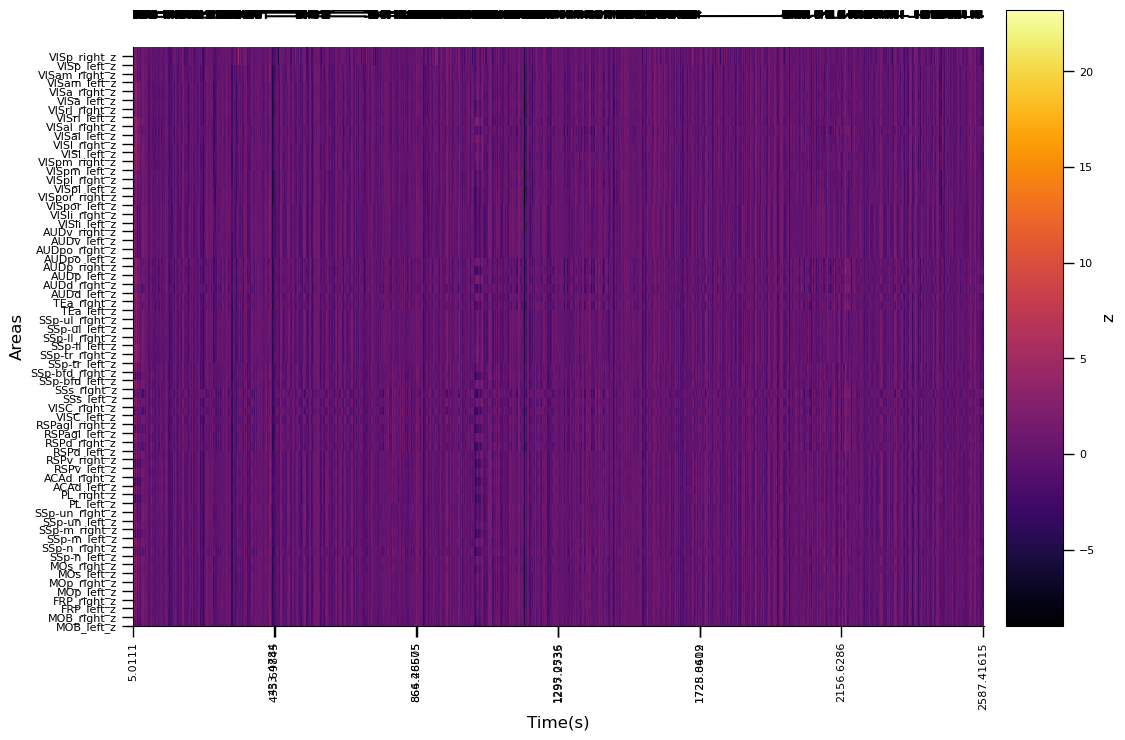

In [133]:
# Define start and end points for the data slice
# start, end = onset_intervals[-1]  

# start -= 25
# end += 50

start, end = 0,data_df.shape[0]
# start, end = 1000,2000

# Initialize lists to store columns and corresponding data
columns_to_plot = []
data_to_plot = []
excluded_columns = []

# Specify the data type ('dFF' or 'z')
data = 'z'

# Iterate over areanames to find existing columns
for area_number in range(len(areanames)):
    area_name = str(areanames[area_number][1])
    column_name = f'{area_name}_{data}'
    if column_name in data_df.columns:
        column_data = data_df[column_name].values
        if not np.isnan(column_data).all():  # Check if the entire column is NaN
            columns_to_plot.append(column_name)
            data_to_plot.append(column_data[start:end])  # Slice data to the specified range
        else:
            excluded_columns.append(column_name)

# Check if any columns exist
if len(columns_to_plot) == 0:
    print("No columns found in the DataFrame.")
else:
    # Create a gridspec with a color bar
    fig = plt.figure(figsize=(12, 8))
    fig.set_facecolor('white')  # Set the figure's background to white

    gs = gridspec.GridSpec(3, 2, width_ratios=[15, 1], height_ratios=[1, 1, len(columns_to_plot)], hspace=0.05, wspace=0.05)
    
    # Plot norm_stim_on as bars on the top left subplot
    ax1 = fig.add_subplot(gs[1, 0])
    # norm_stim_on_values = data_df['norm_stim_on'].values[start:end]
    # ax1.bar(data_df['time_seconds'].values[start:end], norm_stim_on_values, color='black', width=1)
    # ax1.set_xlim([data_df['time_seconds'].values[start], data_df['time_seconds'].values[end-1]])
    ax1.axis('off')  # Turn off the axis

    # Plot rotary encoder data
    ax3 = fig.add_subplot(gs[0, 0])
    encoder_values = data_df['Rotary Encoder'].values[start:end]
    ax3.plot(data_df['time_seconds'].values[start:end], encoder_values, color='black')
    ax3.set_xlim([data_df['time_seconds'].values[start], data_df['time_seconds'].values[end-1]])
    ax3.axis('off')
    
    # # Plot oddball_onsets and reward_onsets as bars
    # oddball_values = data_df['oddball_onsets'].values[start:end]
    # ax1.bar(data_df['time_seconds'].values[start:end], oddball_values, color='red', width=1)

    # reward_values = data_df['reward_onsets'].values[start:end]
    # ax1.bar(data_df['time_seconds'].values[start:end], reward_values, color='purple', width=1)

    # Plot the heatmap on the bottom left subplot
    ax2 = fig.add_subplot(gs[2, 0], sharex=ax1)
    cax = ax2.imshow(data_to_plot, aspect='auto', cmap='inferno', interpolation='nearest', extent=[data_df['time_seconds'].values[start], data_df['time_seconds'].values[end-1], 0, len(columns_to_plot)])
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Areas')

    # Set x-axis ticks for the heatmap
    time_seconds = data_df['time_seconds'].values[start:end]
    ax2.set_xticks(time_seconds[::int(len(time_seconds)/10)])  # Adjust the step for better labeling
    ax2.set_xticklabels(time_seconds[::int(len(time_seconds)/10)], rotation=90)
    
    # Set y-axis ticks for the heatmap
    ax2.set_yticks(range(len(columns_to_plot)))
    ax2.set_yticklabels(columns_to_plot)
    
    # Add a color bar in the right subplot
    cbar_ax = fig.add_subplot(gs[:, 1])
    cbar = fig.colorbar(cax, cax=cbar_ax)
    cbar.set_label(f'{data}')
    ax2.grid(False)
    # plt.show()
# plt.savefig(pjoin(localdisk, '')
# plt.savefig(pjoin(localdisk, 'whole_session.png'))


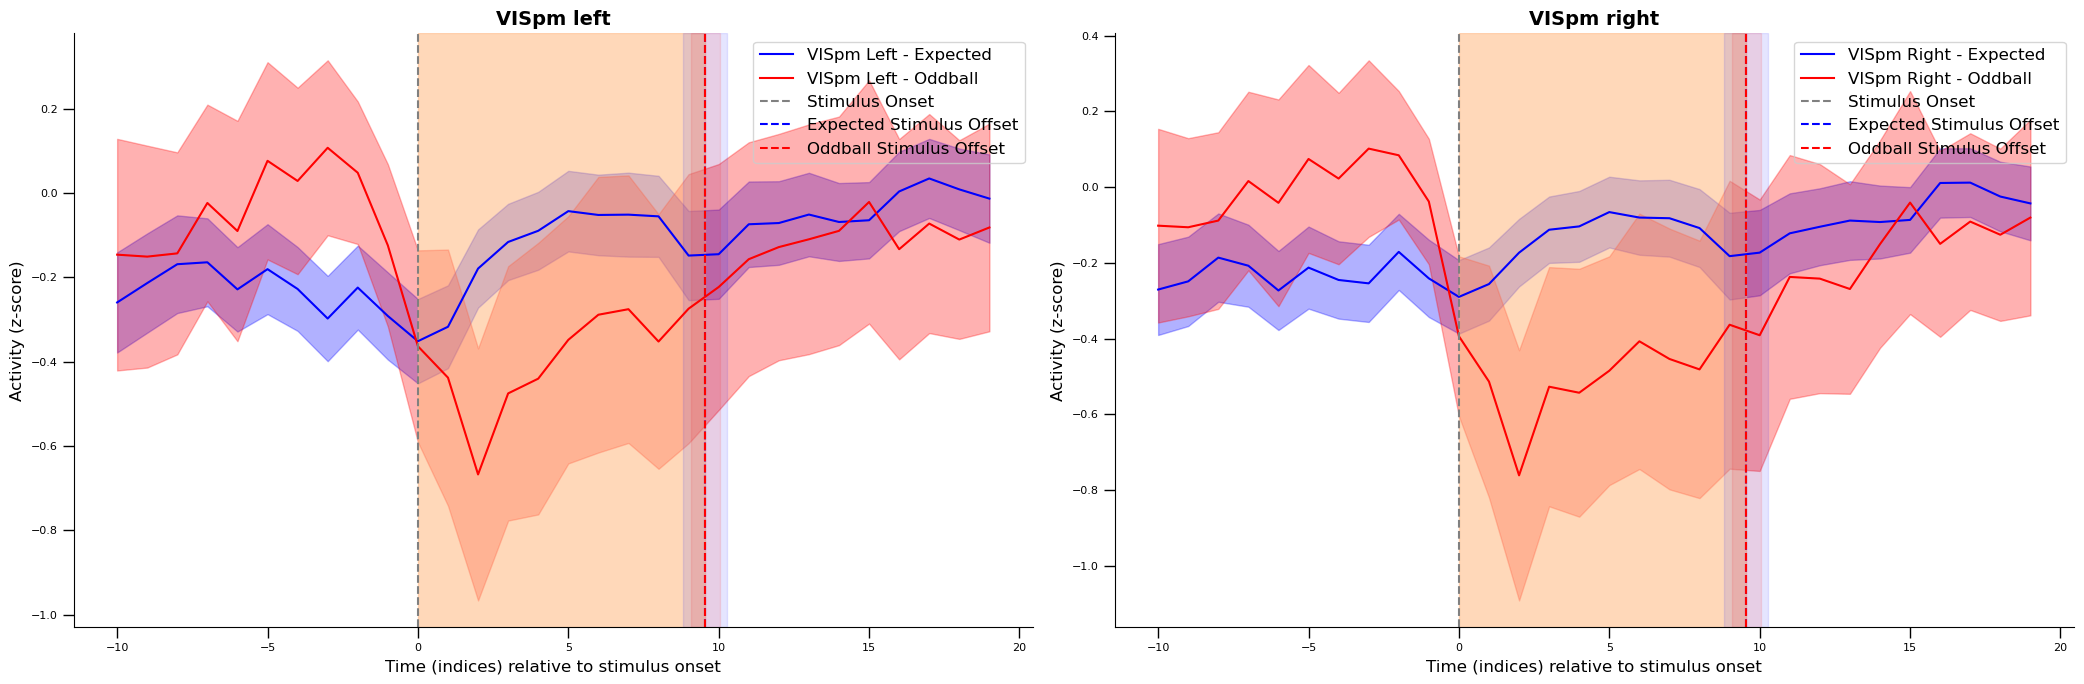

In [134]:
# Select region and data type
region = 'VISpm'
data_type = 'z'

time_window_before = 10  # 10 frames before stimulus onset
time_window_after = 20  # 20 frames after stimulus onset
sides = ['left', 'right']

fig, axs = plt.subplots(nrows=1, ncols=len(sides), figsize=(21, 7))
for i, side in enumerate(sides):
    column_name = f'{region}_{side}_{data_type}'
    
    # Filter dataframe for the selected region and data type
    region_data = data_df[[column_name, 'time_seconds']]
    
    # Initialize lists for peri-stimulus data
    peri_stim_data_expected = []
    peri_stim_data_oddball = []
    offsets_expected = []
    offsets_oddball = []
    
    # Extract indices of stimulus onsets and offsets from stim_df
    exp_onsets = stim_df.loc[stim_df['stim_id'] == 9, 'onset_idx'].tolist()
    odd_onsets = stim_df.loc[stim_df['stim_id'] == 10, 'onset_idx'].tolist()
    exp_offsets = stim_df.loc[stim_df['stim_id'] == 9, 'offset_idx'].tolist()
    odd_offsets = stim_df.loc[stim_df['stim_id'] == 10, 'offset_idx'].tolist()
    exp_mean_dur = stim_df.loc[stim_df['stim_id'] == 9, 'mean_dur'].tolist()
    odd_mean_dur = stim_df.loc[stim_df['stim_id'] == 10, 'mean_dur'].tolist()
    exp_sem_dur = stim_df.loc[stim_df['stim_id'] == 9, 'sem_dur'].tolist()
    odd_sem_dur = stim_df.loc[stim_df['stim_id'] == 10, 'sem_dur'].tolist()
    
    # Extract peri-stimulus data for expected stimuli
    for onset, offset, mean_dur, sem_dur in zip(exp_onsets, exp_offsets, exp_mean_dur, exp_sem_dur):
        start_idx = onset - time_window_before
        end_idx = onset + time_window_after
        if start_idx >= 0 and end_idx < len(region_data):
            peri_stim_data_expected.append(region_data.iloc[start_idx:end_idx][column_name].values)
            offsets_expected.append(offset - onset)
    
    # Extract peri-stimulus data for oddball stimuli
    for onset, offset, mean_dur, sem_dur in zip(odd_onsets, odd_offsets, odd_mean_dur, odd_sem_dur):
        start_idx = onset - time_window_before
        end_idx = onset + time_window_after
        if start_idx >= 0 and end_idx < len(region_data):
            peri_stim_data_oddball.append(region_data.iloc[start_idx:end_idx][column_name].values)
            offsets_oddball.append(offset - onset)

    # Determine the maximum length of the peri-stimulus data
    max_length = max(max(len(x) for x in peri_stim_data_expected), max(len(x) for x in peri_stim_data_oddball))
    
    # Pad or truncate the data to ensure consistent length
    peri_stim_data_expected = [np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan) if len(x) < max_length else x[:max_length] for x in peri_stim_data_expected]
    peri_stim_data_oddball = [np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan) if len(x) < max_length else x[:max_length] for x in peri_stim_data_oddball]

    # Calculate mean activity for expected and oddball stimuli
    mean_activity_expected = np.nanmean(peri_stim_data_expected, axis=0)
    sem_activity_expected = np.nanstd(peri_stim_data_expected, axis=0) / np.sqrt(np.sum(~np.isnan(peri_stim_data_expected), axis=0))
    mean_activity_oddball = np.nanmean(peri_stim_data_oddball, axis=0)
    sem_activity_oddball = np.nanstd(peri_stim_data_oddball, axis=0) / np.sqrt(np.sum(~np.isnan(peri_stim_data_oddball), axis=0))

    ax = axs[i]
    
    # Plot mean activity for expected stimuli
    ax.plot(np.arange(-time_window_before, time_window_after), mean_activity_expected, label=f'{region} {side.capitalize()} - Expected', color='blue')
    ax.fill_between(np.arange(-time_window_before, time_window_after), mean_activity_expected - sem_activity_expected, mean_activity_expected + sem_activity_expected, color='blue', alpha=0.3)
    
    # Plot mean activity for oddball stimuli
    ax.plot(np.arange(-time_window_before, time_window_after), mean_activity_oddball, label=f'{region} {side.capitalize()} - Oddball', color='red')
    ax.fill_between(np.arange(-time_window_before, time_window_after), mean_activity_oddball - sem_activity_oddball, mean_activity_oddball + sem_activity_oddball, color='red', alpha=0.3)
    
    # Plot stimulus onset and offset
    ax.axvline(x=0, linestyle='--', color='gray', label='Stimulus Onset')  # Stimulus onset
    ax.axvline(x=np.mean(exp_mean_dur), linestyle='--', color='blue', label='Expected Stimulus Offset')  # Average offset for expected stimuli
    ax.axvline(x=np.mean(odd_mean_dur), linestyle='--', color='red', label='Oddball Stimulus Offset')  # Average offset for oddball stimuli
    
    # Shade stimulus period
    ax.axvspan(0, np.mean(exp_mean_dur), alpha=0.3, color='orange')  # Stimulus period for expected stimuli
    ax.axvspan(0, np.mean(odd_mean_dur), alpha=0.3, color='pink')  # Stimulus period for oddball stimuli

    # Shade SEM for offsets
    ax.axvspan(exp_mean_dur[0] - exp_sem_dur[0], exp_mean_dur[0] + exp_sem_dur[0], alpha=0.1, color='blue')
    ax.axvspan(odd_mean_dur[0] - odd_sem_dur[0], odd_mean_dur[0] + odd_sem_dur[0], alpha=0.1, color='red')
    
    ax.set_title(f'{region} {side}')
    ax.set_xlabel('Time (indices) relative to stimulus onset')
    ax.set_ylabel('Activity (z-score)')
    ax.legend();
    ax.grid(False)

plt.tight_layout()
# plt.savefig(pjoin(sm_path, f'PSTH/{region}_PSTH.png'))

# plt.show()


In [89]:
print(data_df.shape)
print(stim_df.shape)

(21535, 133)
(320, 8)


In [144]:
stim_df = allstim_df

In [161]:
# Iterate over areanames to find existing columns
for area_number in range(len(areanames)):
    area_name = str(areanames[area_number][1])
    column_name = f'{area_name}_{data}'
    if column_name in data_df.columns:
        column_data = data_df[column_name].values
        if not np.isnan(column_data).all():  # Check if the entire column is NaN
            columns_to_plot.append(column_name)
        else:
            excluded_columns.append(column_name) # This will print the first part of the name
# Use a set to store unique base region names
unique_regions = set()

for region in columns_to_plot:
    base_region_name = region.split('_')[0]
    unique_regions.add(base_region_name)

# Convert the set to a list if needed
unique_regions = list(unique_regions)

before = 10
after = 20
data_type = 'z'
# Print unique base region names
try:
    for region in unique_regions:
        plot_PSTH(data_df, stim_df, region, before, after,data_type);
except Exception as err:
    print(err)


PSTH for SSp-tr in progress...
PSTH for SSp-tr saved...
PSTH for SSs in progress...
PSTH for SSs saved...
PSTH for MOs in progress...
PSTH for MOs saved...
PSTH for MOp in progress...
PSTH for MOp saved...
PSTH for AUDd in progress...
PSTH for AUDd saved...
PSTH for RSPv in progress...
PSTH for RSPv saved...
PSTH for RSPagl in progress...
PSTH for RSPagl saved...
PSTH for SSp-un in progress...
PSTH for SSp-un saved...
PSTH for VISC in progress...
PSTH for VISC saved...
PSTH for AUDv in progress...
PSTH for AUDv saved...
PSTH for FRP in progress...
PSTH for FRP saved...
PSTH for SSp-m in progress...
PSTH for SSp-m saved...
PSTH for VISpor in progress...
PSTH for VISpor saved...
PSTH for AUDp in progress...
PSTH for AUDp saved...
PSTH for VISal in progress...
PSTH for VISal saved...
PSTH for SSp-bfd in progress...
PSTH for SSp-bfd saved...
PSTH for VISl in progress...
PSTH for VISl saved...
PSTH for VISa in progress...
PSTH for VISa saved...
PSTH for VISp in progress...
PSTH for VISp sav

In [156]:
# Iterate over areanames to find existing columns
for area_number in range(len(areanames)):
    area_name = str(areanames[area_number][1])
    column_name = f'{area_name}_{data}'
    if column_name in data_df.columns:
        column_data = data_df[column_name].values
        if not np.isnan(column_data).all():  # Check if the entire column is NaN
            columns_to_plot.append(column_name)
        else:
            excluded_columns.append(column_name) # This will print the first part of the name
# Use a set to store unique base region names
unique_regions = set()

for region in columns_to_plot:
    base_region_name = region.split('_')[0]
    unique_regions.add(base_region_name)

# Convert the set to a list if needed
unique_regions = list(unique_regions)

before = 10
after = 20
data_type = 'z'
# Print unique base region names
try:
    for region in unique_regions:
        plot_allPSTH(data_df, stim_df, region, before, after,data_type);
except Exception as err:
    print(err)


PSTH for SSp-tr in progress...
PSTH for SSp-tr saved...
PSTH for SSs in progress...
PSTH for SSs saved...
PSTH for MOs in progress...
PSTH for MOs saved...
PSTH for MOp in progress...
PSTH for MOp saved...
PSTH for AUDd in progress...
PSTH for AUDd saved...
PSTH for RSPv in progress...
PSTH for RSPv saved...
PSTH for RSPagl in progress...
PSTH for RSPagl saved...
PSTH for SSp-un in progress...
PSTH for SSp-un saved...
PSTH for VISC in progress...
PSTH for VISC saved...
PSTH for AUDv in progress...
PSTH for AUDv saved...
PSTH for FRP in progress...
PSTH for FRP saved...
PSTH for SSp-m in progress...
PSTH for SSp-m saved...
PSTH for VISpor in progress...
PSTH for VISpor saved...
PSTH for AUDp in progress...
PSTH for AUDp saved...
PSTH for VISal in progress...
PSTH for VISal saved...
PSTH for SSp-bfd in progress...
PSTH for SSp-bfd saved...
PSTH for VISl in progress...
PSTH for VISl saved...
PSTH for VISa in progress...
PSTH for VISa saved...
PSTH for VISp in progress...
PSTH for VISp sav

#### SP

In [176]:
# Helper function to calculate mean and SEM
def calculate_mean_sem(data):
    data_array = np.array(data)
    mean_activity = np.nanmean(data_array, axis=0)
    sem_activity = np.nanstd(data_array, axis=0) / np.sqrt(np.sum(~np.isnan(data_array), axis=0))
    return mean_activity, sem_activity

def plot_PSTH_SP(data_df, region, time_window_before, time_window_after, data_type, localdisk):
    sides = ['left', 'right']  # Assuming you want to plot for left and right as before

    fig, axs = plt.subplots(nrows=1, ncols=len(sides), figsize=(21, 7))
    try:
        for i, side in enumerate(sides):
            column_name = f'{region}_{side}_{data_type}'
            if column_name in data_df.columns:
                region_data = data_df[[column_name, 'time_seconds']]

                # Initialize lists for peri-stimulus data
                peri_stim_data_type1 = []
                peri_stim_data_type2 = []

                # Identify onsets and offsets based on stim_type changes
                onsets_type1 = data_df.index[(data_df['stim_type'].shift(1) != 1) & (data_df['stim_type'] == 1)].tolist()
                offsets_type1 = data_df.index[(data_df['stim_type'].shift(-1) != 1) & (data_df['stim_type'] == 1)].tolist()
                onsets_type2 = data_df.index[(data_df['stim_type'].shift(1) != 2) & (data_df['stim_type'] == 2)].tolist()
                offsets_type2 = data_df.index[(data_df['stim_type'].shift(-1) != 2) & (data_df['stim_type'] == 2)].tolist()

                # Extract peri-stimulus data for both types
                for onset in onsets_type1:
                    start_idx = onset - time_window_before
                    end_idx = onset + time_window_after
                    if start_idx >= 0 and end_idx < len(region_data):
                        peri_stim_data_type1.append(region_data.iloc[start_idx:end_idx][column_name].values)
            
                for onset in onsets_type2:
                    start_idx = onset - time_window_before
                    end_idx = onset + time_window_after
                    if start_idx >= 0 and end_idx < len(region_data):
                        peri_stim_data_type2.append(region_data.iloc[start_idx:end_idx][column_name].values)

                # Calculate mean and SEM of activity for both types
                mean_activity_type1, sem_activity_type1 = calculate_mean_sem(peri_stim_data_type1)
                mean_activity_type2, sem_activity_type2 = calculate_mean_sem(peri_stim_data_type2)

                ax = axs[i]
                time_range = np.arange(-time_window_before, time_window_after)

                # Plotting
                ax.plot(time_range, mean_activity_type1, label=f'{region} {side.capitalize()} - Type 1', color='blue')
                ax.fill_between(time_range, mean_activity_type1 - sem_activity_type1, mean_activity_type1 + sem_activity_type1, color='blue', alpha=0.3)
                ax.plot(time_range, mean_activity_type2, label=f'{region} {side.capitalize()} - Type 2', color='red')
                ax.fill_between(time_range, mean_activity_type2 - sem_activity_type2, mean_activity_type2 + sem_activity_type2, color='red', alpha=0.3)
                
                ax.axvline(x=0, linestyle='--', color='gray', label='Stimulus Onset')
                ax.set_title(f'{region} {side}')
                ax.set_xlabel('Time (indices) relative to stimulus onset')
                ax.set_ylabel('Activity (z-score)')
                ax.legend()
                ax.grid(False)

            else:
                print(f"Column {column_name} does not exist in DataFrame.")

        plt.tight_layout()
        plt.savefig(pjoin(localdisk, f'PSTH/{region}_PSTH.png'))
        print(f"PSTH for {region} saved...")
        plt.close(fig)
    except Exception as err:
        print(f"Error plotting PSTH for {region} {side}: {err}")





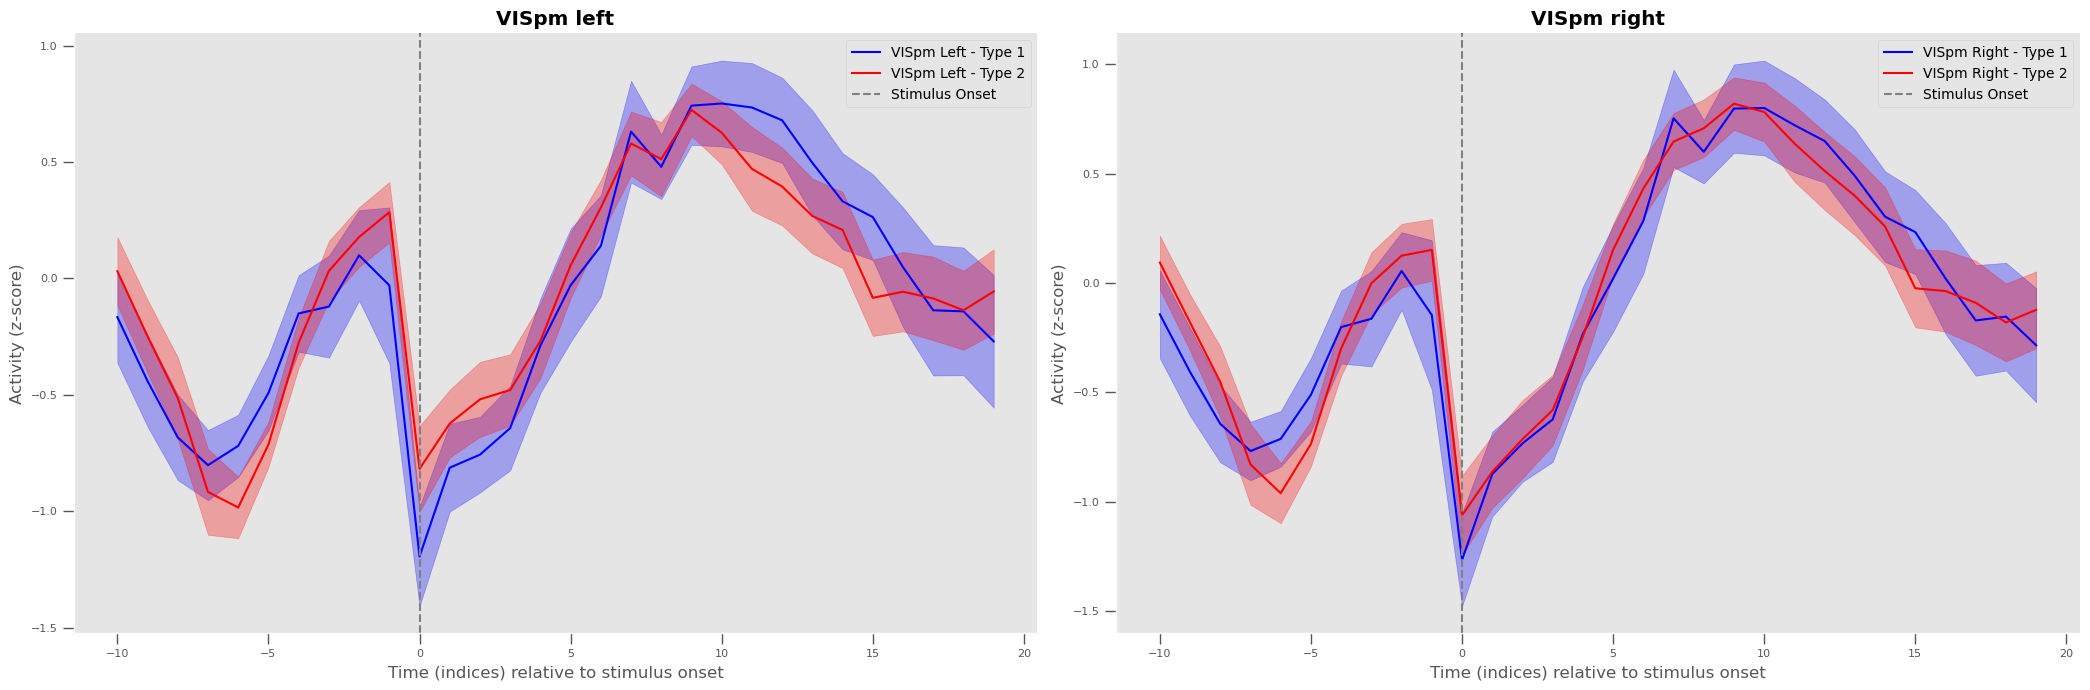

In [168]:
# Parameters
region = 'VISpm'
data_type = 'z'
time_window_before = 10
time_window_after = 20
sides = ['left', 'right']

fig, axs = plt.subplots(nrows=1, ncols=len(sides), figsize=(21, 7))

# Assuming you already have 'stim_type' in your data_df
for i, side in enumerate(sides):
    column_name = f'{region}_{side}_{data_type}'
    region_data = data_df[[column_name, 'time_seconds']]

    # Initialize lists for peri-stimulus data
    peri_stim_data_type1 = []
    peri_stim_data_type2 = []

    # Identify onsets and offsets based on stim_type changes
    onsets_type1 = data_df.index[(data_df['stim_type'].shift(1) != 1) & (data_df['stim_type'] == 1)].tolist()
    offsets_type1 = data_df.index[(data_df['stim_type'].shift(-1) != 1) & (data_df['stim_type'] == 1)].tolist()
    onsets_type2 = data_df.index[(data_df['stim_type'].shift(1) != 2) & (data_df['stim_type'] == 2)].tolist()
    offsets_type2 = data_df.index[(data_df['stim_type'].shift(-1) != 2) & (data_df['stim_type'] == 2)].tolist()

    # Extract peri-stimulus data for both types
    for onset in onsets_type1:
        start_idx = onset - time_window_before
        end_idx = onset + time_window_after
        if start_idx >= 0 and end_idx < len(region_data):
            peri_stim_data_type1.append(region_data.iloc[start_idx:end_idx][column_name].values)
    
    for onset in onsets_type2:
        start_idx = onset - time_window_before
        end_idx = onset + time_window_after
        if start_idx >= 0 and end_idx < len(region_data):
            peri_stim_data_type2.append(region_data.iloc[start_idx:end_idx][column_name].values)

    # Calculate mean and SEM of activity for both types
    mean_activity_type1, sem_activity_type1 = calculate_mean_sem(peri_stim_data_type1)
    mean_activity_type2, sem_activity_type2 = calculate_mean_sem(peri_stim_data_type2)

    ax = axs[i]
    time_range = np.arange(-time_window_before, time_window_after)

    # Plotting
    ax.plot(time_range, mean_activity_type1, label=f'{region} {side.capitalize()} - Type 1', color='blue')
    ax.fill_between(time_range, mean_activity_type1 - sem_activity_type1, mean_activity_type1 + sem_activity_type1, color='blue', alpha=0.3)
    ax.plot(time_range, mean_activity_type2, label=f'{region} {side.capitalize()} - Type 2', color='red')
    ax.fill_between(time_range, mean_activity_type2 - sem_activity_type2, mean_activity_type2 + sem_activity_type2, color='red', alpha=0.3)
    
    ax.axvline(x=0, linestyle='--', color='gray', label='Stimulus Onset')
    ax.set_title(f'{region} {side}')
    ax.set_xlabel('Time (indices) relative to stimulus onset')
    ax.set_ylabel('Activity (z-score)')
    ax.legend()
    ax.grid(False)

plt.tight_layout()
# plt.savefig(pjoin(localdisk, f'PSTH/{region}_PSTH.png'))



In [180]:
localdisk

'/datajoint-data/data/aeltona/AA_ROS-1688_2024_01_27_scan000EAEIO_sess000EAEIO'

In [181]:

# Iterate over areanames to find existing columns
for area_number in range(len(areanames)):
    area_name = str(areanames[area_number][1])
    column_name = f'{area_name}_{data}'
    if column_name in data_df.columns:
        column_data = data_df[column_name].values
        if not np.isnan(column_data).all():  # Check if the entire column is NaN
            columns_to_plot.append(column_name)
        else:
            excluded_columns.append(column_name) # This will print the first part of the name
# Use a set to store unique base region names
unique_regions = set()

for region in columns_to_plot:
    base_region_name = region.split('_')[0]
    unique_regions.add(base_region_name)

# Convert the set to a list if needed
unique_regions = list(unique_regions)

try:
    for region in unique_regions:
        plot_PSTH_SP(data_df, region, 10, 20, 'dFF', localdisk)
except Exception as err:
    print(f"Error: {err}")

PSTH for SSp-n saved...
PSTH for VISp saved...
PSTH for VISrl saved...
PSTH for SSp-tr saved...
PSTH for SSp-ul saved...
PSTH for AUDd saved...
PSTH for AUDv saved...
PSTH for VISal saved...
PSTH for MOs saved...
PSTH for AUDpo saved...
PSTH for SSs saved...
PSTH for VISli saved...
PSTH for VISam saved...
PSTH for VISl saved...
PSTH for VISpor saved...
PSTH for SSp-ll saved...
PSTH for MOp saved...
PSTH for SSp-m saved...
PSTH for VISpl saved...
PSTH for PL saved...
PSTH for SSp-bfd saved...
PSTH for ACAd saved...
PSTH for AUDp saved...
PSTH for TEa saved...
PSTH for VISpm saved...
PSTH for VISa saved...
PSTH for SSp-un saved...
PSTH for RSPv saved...
PSTH for RSPd saved...
PSTH for RSPagl saved...


In [32]:

tif_files = [f for f in os.listdir(localdisk) if f.endswith('.tif')]

filename_parts = re.split(r'_|\.', tif_files[0])
scan_info = '_'.join(filename_parts[0:4])

csv_path = pjoin(localdisk, scan_info+'_stim_data.csv')
print(csv_path)

/datajoint-data/data/aeltona/AA_ROS-1706_2024-03-12_scan9FN2ANVG_sess9FN2ANVG/scan9FN2ANVG_Oddball_AA_ROS-1706_stim_data.csv


In [33]:
stim_df.to_csv(csv_path, index=False)

# garb

In [ ]:
# Select region and data type
region = 'ACAd'
data_type = 'z'
sides = ['left', 'right']
time_window_before = 5  # 5 seconds before stimulus onset
time_window_after = 10  # 10 seconds after stimulus offset

fig, axs = plt.subplots(nrows=1, ncols=len(sides), figsize=(15, 5))

for i, side in enumerate(sides):
    column_name = f'{region}_{side}_{data_type}'
    
    # Filter dataframe for the selected region and data type
    region_data = data_df[[column_name, 'norm_stim_on', 'oddball_onsets', 'norm_stim_id', 'time_seconds']]
    
    # Initialize lists for peri-stimulus data
    peri_stim_data_expected = []
    peri_stim_data_oddball = []
    offsets_expected = []
    offsets_oddball = []
    
    stim_onsets = region_data.index[region_data['norm_stim_on'] == 1].tolist()
    oddball_onsets = region_data.index[region_data['oddball_onsets'] == 1].tolist()
    expected_stimuli_indices = [idx for idx in stim_onsets if region_data.at[idx, 'norm_stim_id'] == 9 and idx not in oddball_onsets]

    # Extract peri-stimulus data for expected stimuli
    for onset in expected_stimuli_indices:
        offset = region_data.index[(region_data.index > onset) & (region_data['norm_stim_on'] == 0)].tolist()
        if offset:
            offset = offset[0]
            offsets_expected.append(offset - onset)
            start_idx = onset - time_window_before
            end_idx = offset + time_window_after
            if start_idx >= 0 and end_idx < len(region_data):
                peri_stim_data_expected.append(region_data.iloc[start_idx:end_idx][column_name].values)

    # Extract peri-stimulus data for oddball stimuli
    for onset in oddball_onsets:
        offset = region_data.index[(region_data.index > onset) & (region_data['norm_stim_on'] == 0)].tolist()
        if offset:
            offset = offset[0]
            offsets_oddball.append(offset - onset)
            start_idx = onset - time_window_before
            end_idx = offset + time_window_after
            if start_idx >= 0 and end_idx < len(region_data):
                peri_stim_data_oddball.append(region_data.iloc[start_idx:end_idx][column_name].values)

    # Determine the maximum length of the peri-stimulus data
    max_length = max(max(len(x) for x in peri_stim_data_expected), max(len(x) for x in peri_stim_data_oddball))

    # Pad or truncate the data to ensure consistent length
    peri_stim_data_expected = [np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan) if len(x) < max_length else x[:max_length] for x in peri_stim_data_expected]
    peri_stim_data_oddball = [np.pad(x, (0, max_length - len(x)), 'constant', constant_values=np.nan) if len(x) < max_length else x[:max_length] for x in peri_stim_data_oddball]

    # Calculate mean and SEM for expected stimuli
    peri_stim_data_expected = np.array(peri_stim_data_expected)
    mean_activity_expected = np.nanmean(peri_stim_data_expected, axis=0)
    sem_activity_expected = np.nanstd(peri_stim_data_expected, axis=0) / np.sqrt(np.sum(~np.isnan(peri_stim_data_expected), axis=0))
    
    # Calculate mean and SEM for oddball stimuli
    peri_stim_data_oddball = np.array(peri_stim_data_oddball)
    mean_activity_oddball = np.nanmean(peri_stim_data_oddball, axis=0)
    sem_activity_oddball = np.nanstd(peri_stim_data_oddball, axis=0) / np.sqrt(np.sum(~np.isnan(peri_stim_data_oddball), axis=0))
    
    time_vector = np.linspace(-time_window_before, time_window_after, max_length)  # Adjust time vector for the peri-stimulus window

    # Calculate average and SEM for offsets
    mean_offset_expected = np.mean(offsets_expected)
    sem_offset_expected = np.std(offsets_expected) / np.sqrt(len(offsets_expected))
    mean_offset_oddball = np.mean(offsets_oddball)
    sem_offset_oddball = np.std(offsets_oddball) / np.sqrt(len(offsets_oddball))

    ax = axs[i]
    
    # Plot mean activity for expected stimuli
    ax.plot(time_vector, mean_activity_expected, label=f'{region} {side.capitalize()} - Expected', color='blue')
    ax.fill_between(time_vector, mean_activity_expected - sem_activity_expected, mean_activity_expected + sem_activity_expected, color='blue', alpha=0.3)
    
    # Plot mean activity for oddball stimuli
    ax.plot(time_vector, mean_activity_oddball, label=f'{region} {side.capitalize()} - Oddball', color='red')
    ax.fill_between(time_vector, mean_activity_oddball - sem_activity_oddball, mean_activity_oddball + sem_activity_oddball, color='red', alpha=0.3)
    
    # Plot stimulus onset and offset
    ax.axvline(x=0, linestyle='--', color='gray', label='Stimulus Onset')  # Stimulus onset
    ax.axvline(x=mean_offset_expected, linestyle='--', color='blue', label='Expected Stimulus Offset')  # Average offset for expected stimuli
    ax.axvline(x=mean_offset_oddball, linestyle='--', color='red', label='Oddball Stimulus Offset')  # Average offset for oddball stimuli
    
    # Shade stimulus period
    ax.axvspan(0, mean_offset_expected, alpha=0.3, color='orange')
    
    # Shade SEM for offsets
    ax.axvspan(mean_offset_expected - sem_offset_expected, mean_offset_expected + sem_offset_expected, alpha=0.1, color='blue')
    ax.axvspan(mean_offset_oddball - sem_offset_oddball, mean_offset_oddball + sem_offset_oddball, alpha=0.1, color='red')
    
    ax.set_title(f'Peri-stimulus Activity - {side.capitalize()} Side')
    ax.set_xlabel('Time (s) relative to stimulus onset')
    ax.set_ylabel('Activity (z-score)')
    ax.legend('_')
    ax.grid(False)

plt.tight_layout()
plt.show()